# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


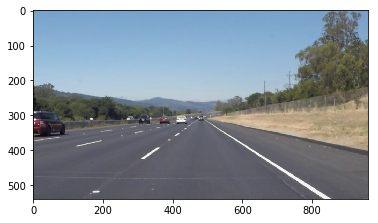

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [108]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_lane_lines = []
    left_lane_lines = []

    for line in lines:
        x1 = line[0][0]
        y1 = line[0][1]
        x2 = line[0][2]
        y2 = line[0][3]        
        slope = ((y2 - y1) / (x2 - x1))
        
        if y1 > 350:
            if(slope > 0):
                if 0.9 > slope > 0.6:
                    right_lane_lines.append(line)
            else:
                if -0.9 < slope < -0.6:
                    left_lane_lines.append(line)
            
    if(len(right_lane_lines) > 0):
        x11, y11, x12, y12 = average_of_lane_lines(right_lane_lines)
        cv2.line(img, (x11, y11), (x12, y12), color, thickness)

    if(len(left_lane_lines) > 0):
        x21, y21, x22, y22 = average_of_lane_lines(left_lane_lines)
        cv2.line(img, (x21, y21), (x22, y22), color, thickness)
        

def average_of_lane_lines(lane_lines):
    x11 = y11 = x12 = y12 = 0
    no_of_lines = len(lane_lines)
    
    for line in lane_lines:
        line = line[0]
        x11 += line[0]
        y11 += line[1]
        x12 += line[2]
        y12 += line[3]
    
    return int(x11 / no_of_lines), int(y11 / no_of_lines), int(x12 / no_of_lines), int(y12 / no_of_lines)

def draw_lines_orig(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['output_output_solidWhiteCurve.jpg',
 'output_output_solidWhiteRight.jpg',
 'output_solidWhiteCurve.jpg',
 'output_solidWhiteRight.jpg',
 'output_solidYellowCurve.jpg',
 'output_solidYellowCurve2.jpg',
 'output_solidYellowLeft.jpg',
 'output_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

import time

def apply_pipeline(input_image):
    #img_path = "test_images/" + input_image
    #read_image = mpimg.imread(img_path)
    read_image = input_image 
    output = grayscale(read_image)
    
    kernel_size = 7
    output = gaussian_blur(output, kernel_size) 
    low_threshold = 190
    high_threshold = 200
    output = canny(output, low_threshold, high_threshold)
    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 90 #minimum number of pixels making up a line
    max_line_gap = 180   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) * 0 # creating a blank to draw lines on

    output = hough_lines(output, 
                         rho,
                         theta,
                         threshold,
                         min_line_length,
                         max_line_gap)
    
    vertices = np.array([[
    (0, 540),
    (480, 270), 
    (960, 540)
    ]], dtype=np.int32)
    output = region_of_interest(output, vertices)

    output = weighted_img(output, read_image)
    #plt.imshow(output, cmap='gray')
    #cv2.imwrite('test_images/' + 'output_' + input_image, output)
    return output

# if __name__ == "__main__":
#     input_images = os.listdir('test_images/')
#     for x in input_images[:3]:
#         apply_pipeline(x)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = apply_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [109]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 59.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.18 s, sys: 1.05 s, total: 4.22 s
Wall time: 4.21 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [73]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.603278688525
[[106 537 411 353]]
LEFT==========================
-0.627615062762
[[162 514 401 364]]
LEFT==========================
-0.648706896552
[[128 537 592 236]]
LEFT==========================
0.69696969697
[[658 428 757 497]]
RIGHT==========================
-0.58024691358
[[108 536 351 395]]
LEFT==========================
-0.602459016393
[[176 494 420 347]]
LEFT==========================
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 6/682 [00:00<00:12, 52.82it/s]

-0.603278688525
[[106 537 411 353]]
LEFT==========================
-0.627615062762
[[162 514 401 364]]
LEFT==========================
-0.648706896552
[[128 537 592 236]]
LEFT==========================
0.69696969697
[[658 428 757 497]]
RIGHT==========================
-0.58024691358
[[108 536 351 395]]
LEFT==========================
-0.602459016393
[[176 494 420 347]]
LEFT==========================
-0.602605863192
[[108 536 415 351]]
LEFT==========================
-0.624615384615
[[196 493 521 290]]
LEFT==========================
-0.604651162791
[[107 538 322 408]]
LEFT==========================
-0.627659574468
[[127 537 315 419]]
LEFT==========================
-0.603773584906
[[313 412 419 348]]
LEFT==========================
-0.602739726027
[[108 537 400 361]]
LEFT==========================
-0.645833333333
[[156 521 348 397]]
LEFT==========================
-0.649350649351
[[129 538 283 438]]
LEFT==========================
-0.6038647343
[[205 478 412 353]]
LEFT==========================

  3%|▎         | 18/682 [00:00<00:12, 51.80it/s]

-0.628571428571
[[128 535 338 403]]
LEFT==========================
-0.672131147541
[[146 537 390 373]]
LEFT==========================
-0.674528301887
[[177 517 389 374]]
LEFT==========================
0.622754491018
[[563 354 730 458]]
RIGHT==========================
-0.629139072848
[[219 477 370 382]]
LEFT==========================
0.197530864198
[[789 374 951 406]]
RIGHT==========================
-0.628571428571
[[126 537 231 471]]
LEFT==========================
-0.666666666667
[[317 416 422 346]]
LEFT==========================
-0.649202733485
[[154 521 593 236]]
LEFT==========================
-0.673819742489
[[151 535 384 378]]
LEFT==========================
-0.649659863946
[[128 537 422 346]]
LEFT==========================
0.675531914894
[[564 356 752 483]]
RIGHT==========================
-0.649635036496
[[231 472 368 383]]
LEFT==========================
0.626865671642
[[567 355 768 481]]
RIGHT==========================
-0.676229508197
[[147 537 391 372]]
LEFT======================

  4%|▍         | 30/682 [00:00<00:12, 51.91it/s]

-0.701117318436
[[154 537 512 286]]
LEFT==========================
-0.673992673993
[[146 530 419 346]]
LEFT==========================
-0.701949860724
[[154 538 513 286]]
LEFT==========================
-0.676870748299
[[133 538 427 339]]
LEFT==========================
0.230769230769
[[696 354 956 414]]
RIGHT==========================
-0.701117318436
[[154 537 512 286]]
LEFT==========================
-0.701960784314
[[154 538 409 359]]
LEFT==========================
-0.674757281553
[[209 488 415 349]]
LEFT==========================
-0.675767918089
[[133 538 426 340]]
LEFT==========================
0.649006622517
[[559 354 710 452]]
RIGHT==========================
0.620253164557
[[561 351 719 449]]
RIGHT==========================
0.231075697211
[[704 356 955 414]]
RIGHT==========================
0.622641509434
[[564 352 723 451]]
RIGHT==========================
-0.671586715867
[[240 469 511 287]]
LEFT==========================
-0.701195219124
[[156 537 407 361]]
LEFT======================

  5%|▌         | 36/682 [00:00<00:12, 52.20it/s]

-0.700421940928
[[153 533 390 367]]
LEFT==========================
-0.726224783862
[[166 537 513 285]]
LEFT==========================
0.222222222222
[[824 375 914 395]]
RIGHT==========================
-0.778761061947
[[307 436 420 348]]
LEFT==========================
0.210526315789
[[817 378 912 398]]
RIGHT==========================
-0.67578125
[[145 537 401 364]]
LEFT==========================
-0.754545454545
[[316 421 426 338]]
LEFT==========================
-0.726708074534
[[169 536 330 419]]
LEFT==========================
-0.701244813278
[[146 538 387 369]]
LEFT==========================
-0.754098360656
[[228 494 411 356]]
LEFT==========================
-0.754032258065
[[170 536 418 349]]
LEFT==========================
-0.72602739726
[[263 458 409 352]]
LEFT==========================
0.207207207207
[[839 383 950 406]]
RIGHT==========================
-0.726851851852
[[212 493 428 336]]
LEFT==========================
-0.753768844221
[[209 508 408 358]]
LEFT==========================


  6%|▌         | 42/682 [00:00<00:12, 52.73it/s]

-0.703862660944
[[145 537 378 373]]
LEFT==========================
-0.754310344828
[[167 537 399 362]]
LEFT==========================
-0.70110701107
[[145 538 416 348]]
LEFT==========================
-0.77950310559
[[168 536 490 285]]
LEFT==========================
0.235294117647
[[747 356 917 396]]
RIGHT==========================
-0.754166666667
[[169 535 409 354]]
LEFT==========================
-0.70243902439
[[144 538 349 394]]
LEFT==========================
-0.703862660944
[[152 531 385 367]]
LEFT==========================
-0.752525252525
[[186 523 384 374]]
LEFT==========================
-0.779069767442
[[166 537 424 336]]
LEFT==========================
0.213197969543
[[757 363 954 405]]
RIGHT==========================
-0.752631578947
[[198 514 388 371]]
LEFT==========================
-0.700440528634
[[144 537 371 378]]
LEFT==========================
-0.756
[[166 537 416 348]]
LEFT==========================
-0.700507614213
[[147 536 344 398]]
LEFT==========================
-0.7531

  7%|▋         | 47/682 [00:00<00:12, 51.65it/s]

-0.704761904762
[[146 538 356 390]]
LEFT==========================
-0.754166666667
[[168 537 408 356]]
LEFT==========================
-0.753012048193
[[204 511 370 386]]
LEFT==========================
-0.7
[[148 537 408 355]]
LEFT==========================
0.230215827338
[[724 357 863 389]]
RIGHT==========================
-0.751633986928
[[340 401 493 286]]
LEFT==========================
-0.753138075314
[[166 538 405 358]]
LEFT==========================
-0.701657458564
[[147 537 328 410]]
LEFT==========================
-0.701680672269
[[145 537 383 370]]
LEFT==========================
-0.752577319588
[[207 508 401 362]]
LEFT==========================
-0.754966887417
[[342 400 493 286]]
LEFT==========================
-0.755186721992
[[167 537 408 355]]
LEFT==========================
-0.755274261603
[[168 537 405 358]]
LEFT==========================
-0.700483091787
[[146 537 353 392]]
LEFT==========================
-0.753488372093
[[186 524 401 362]]
LEFT==========================
0.2244

  8%|▊         | 52/682 [00:01<00:12, 50.84it/s]


[[167 537 406 357]]
LEFT==========================
-0.699507389163
[[145 537 348 395]]
LEFT==========================
0.62323943662
[[568 359 852 536]]
RIGHT==========================
-0.709677419355
[[316 416 409 350]]
LEFT==========================
-0.723926380368
[[163 526 489 290]]
LEFT==========================
-0.701754385965
[[143 538 371 378]]
LEFT==========================
-0.751004016064
[[166 537 415 350]]
LEFT==========================
-0.753424657534
[[194 517 413 352]]
LEFT==========================
0.577464788732
[[594 374 878 538]]
RIGHT==========================
-0.703846153846
[[145 536 405 353]]
LEFT==========================
0.577049180328
[[572 362 877 538]]
RIGHT==========================
-0.702702702703
[[144 538 366 382]]
LEFT==========================
-0.75
[[169 535 413 352]]
LEFT==========================
-0.703007518797
[[145 536 411 349]]
LEFT==========================
0.576666666667
[[577 365 877 538]]
RIGHT==========================
-0.75
[[164 538 280 4

  8%|▊         | 57/682 [00:01<00:12, 48.82it/s]

-0.702380952381
[[143 538 395 361]]
LEFT==========================
-0.753205128205
[[179 527 491 292]]
LEFT==========================
-0.753246753247
[[258 469 412 353]]
LEFT==========================
-0.723214285714
[[265 454 489 292]]
LEFT==========================
-0.700787401575
[[142 538 396 360]]
LEFT==========================
-0.753571428571
[[212 502 492 291]]
LEFT==========================
-0.751515151515
[[248 476 413 352]]
LEFT==========================
0.230769230769
[[707 355 824 382]]
RIGHT==========================
-0.725
[[270 450 430 334]]
LEFT==========================
-0.702702702703
[[142 538 401 356]]
LEFT==========================
-0.75
[[211 503 411 353]]
LEFT==========================
-0.753048780488
[[164 537 492 290]]
LEFT==========================
-0.700507614213
[[147 535 344 397]]
LEFT==========================
-0.703180212014
[[141 538 424 339]]
LEFT==========================
0.228346456693
[[720 357 847 386]]
RIGHT==========================
-0.70081967213

  9%|▉         | 62/682 [00:01<00:13, 47.45it/s]

-0.726890756303
[[159 537 397 364]]
LEFT==========================
-0.697278911565
[[198 497 492 292]]
LEFT==========================
-0.700854700855
[[140 537 491 291]]
LEFT==========================
-0.727659574468
[[164 533 399 362]]
LEFT==========================
0.626506024096
[[556 354 722 458]]
RIGHT==========================
-0.699074074074
[[275 444 491 293]]
LEFT==========================
0.226744186047
[[787 373 959 412]]
RIGHT==========================
0.212686567164
[[689 351 957 408]]
RIGHT==========================
-0.724279835391
[[157 537 400 361]]
LEFT==========================
-0.674772036474
[[171 513 500 291]]
LEFT==========================
-0.726141078838
[[158 537 399 362]]
LEFT==========================
-0.679245283019
[[136 538 295 430]]
LEFT==========================
0.625
[[660 420 756 480]]
RIGHT==========================
-0.698961937716
[[203 493 492 291]]
LEFT==========================


 10%|▉         | 67/682 [00:01<00:13, 45.64it/s]

-0.699248120301
[[225 478 491 292]]
LEFT==========================
-0.725
[[158 537 398 363]]
LEFT==========================
0.623966942149
[[562 358 804 509]]
RIGHT==========================
-0.699570815451
[[194 499 427 336]]
LEFT==========================
-0.69387755102
[[138 537 236 469]]
LEFT==========================
0.622950819672
[[563 358 807 510]]
RIGHT==========================
-0.700483091787
[[285 437 492 292]]
LEFT==========================
-0.698961937716
[[202 494 491 292]]
LEFT==========================
-0.725225225225
[[195 511 417 350]]
LEFT==========================
0.62323943662
[[566 361 850 538]]
RIGHT==========================
-0.72480620155
[[158 537 416 350]]
LEFT==========================
-0.699481865285
[[296 430 489 295]]
LEFT==========================
0.600682593857
[[571 358 864 534]]
RIGHT==========================
-0.675159235669
[[136 538 293 432]]
LEFT==========================
0.622377622378
[[704 448 847 537]]
RIGHT==========================
-0.7248

 11%|█         | 72/682 [00:01<00:14, 41.31it/s]

-0.67619047619
[[138 538 348 396]]
LEFT==========================
-0.676113360324
[[138 537 385 370]]
LEFT==========================
-0.72625698324
[[227 489 406 359]]
LEFT==========================
-0.724137931034
[[158 538 303 433]]
LEFT==========================
0.217821782178
[[821 378 922 400]]
RIGHT==========================
0.212121212121
[[820 381 919 402]]
RIGHT==========================
-0.752293577982
[[210 501 428 337]]
LEFT==========================
0.620320855615
[[610 391 797 507]]
RIGHT==========================
-0.673913043478
[[138 537 368 382]]
LEFT==========================
-0.725274725275
[[220 494 402 362]]
LEFT==========================
-0.726726726727
[[158 538 491 296]]
LEFT==========================
0.210526315789
[[845 383 959 407]]
RIGHT==========================
0.642857142857
[[549 351 675 432]]
RIGHT==========================
0.223300970874
[[844 386 947 409]]
RIGHT==========================
-0.7
[[254 460 414 348]]
LEFT==========================
-0.67555

 11%|█▏        | 77/682 [00:01<00:15, 38.88it/s]

-0.678391959799
[[140 538 339 403]]
LEFT==========================
-0.726443768997
[[160 538 489 299]]
LEFT==========================
0.624113475177
[[682 439 823 527]]
RIGHT==========================
-0.676991150442
[[140 537 366 384]]
LEFT==========================
-0.75
[[175 527 407 353]]
LEFT==========================
-0.678111587983
[[139 537 372 379]]
LEFT==========================
-0.725903614458
[[159 538 491 297]]
LEFT==========================
0.624060150376
[[707 455 840 538]]
RIGHT==========================
-0.726351351351
[[193 514 489 299]]
LEFT==========================
-0.676470588235
[[139 538 309 423]]
LEFT==========================
0.624060150376
[[708 455 841 538]]
RIGHT==========================
-0.721153846154
[[322 414 426 339]]
LEFT==========================


 12%|█▏        | 82/682 [00:01<00:15, 39.77it/s]

-0.677272727273
[[139 537 359 388]]
LEFT==========================
-0.727272727273
[[160 537 490 297]]
LEFT==========================
0.598615916955
[[571 365 860 538]]
RIGHT==========================
-0.7
[[256 459 416 347]]
LEFT==========================
-0.726618705036
[[211 501 489 299]]
LEFT==========================
-0.696581196581
[[191 503 425 340]]
LEFT==========================
0.649769585253
[[571 366 788 507]]
RIGHT==========================
-0.724832214765
[[192 514 490 298]]
LEFT==========================
-0.674641148325
[[138 537 347 396]]
LEFT==========================
-0.725075528701
[[159 537 490 297]]
LEFT==========================
0.599221789883
[[603 384 860 538]]
RIGHT==========================
-0.7
[[213 488 423 341]]
LEFT==========================
0.211428571429
[[746 365 921 402]]
RIGHT==========================
-0.676470588235
[[137 538 341 400]]
LEFT==========================
-0.725631768953
[[213 499 490 298]]
LEFT==========================
-0.725609756098
[

 13%|█▎        | 87/682 [00:01<00:14, 41.08it/s]


[[134 537 488 298]]
LEFT==========================
-0.722826086957
[[156 537 340 404]]
LEFT==========================
-0.674157303371
[[133 538 489 298]]
LEFT==========================
0.211538461538
[[853 389 957 411]]
RIGHT==========================
0.210256410256
[[764 366 959 407]]
RIGHT==========================
-0.725274725275
[[306 430 397 364]]
LEFT==========================
-0.723404255319
[[204 503 392 367]]
LEFT==========================
0.647058823529
[[587 369 689 435]]
RIGHT==========================
-0.677966101695
[[244 462 421 342]]
LEFT==========================
-0.67323943662
[[132 538 487 299]]
LEFT==========================
-0.704433497537
[[189 511 392 368]]
LEFT==========================
0.651315789474
[[553 354 705 453]]
RIGHT==========================
-0.701986754967
[[153 537 304 431]]
LEFT==========================
-0.674740484429
[[132 537 421 342]]
LEFT==========================
0.214574898785
[[712 358 959 411]]
RIGHT==========================
0.212290502

 13%|█▎        | 92/682 [00:01<00:13, 42.29it/s]

-0.702205882353
[[151 537 423 346]]
LEFT==========================
-0.671698113208
[[224 476 489 298]]
LEFT==========================
0.230769230769
[[802 376 958 412]]
RIGHT==========================
-0.700819672131
[[150 537 394 366]]
LEFT==========================
-0.6735395189
[[130 538 421 342]]
LEFT==========================
-0.674757281553
[[191 498 397 359]]
LEFT==========================
0.625531914894
[[561 354 796 501]]
RIGHT==========================
0.650224215247
[[558 357 781 502]]
RIGHT==========================
-0.700934579439
[[150 538 364 388]]
LEFT==========================
-0.703539823009
[[151 538 377 379]]
LEFT==========================
-0.674157303371
[[151 525 418 345]]
LEFT==========================
-0.672413793103
[[130 538 420 343]]
LEFT==========================
0.650735294118
[[563 361 835 538]]
RIGHT==========================
-0.701183431953
[[151 537 489 300]]
LEFT==========================
-0.673684210526
[[132 538 417 346]]
LEFT========================

 14%|█▍        | 97/682 [00:02<00:13, 43.35it/s]

-0.673758865248
[[137 538 419 348]]
LEFT==========================
-0.700906344411
[[157 537 488 305]]
LEFT==========================
-0.702380952381
[[159 537 411 360]]
LEFT==========================
-0.674528301887
[[201 496 413 353]]
LEFT==========================
0.225563909774
[[718 363 851 393]]
RIGHT==========================
-0.674418604651
[[194 501 409 356]]
LEFT==========================
-0.675958188153
[[138 538 425 344]]
LEFT==========================
-0.701244813278
[[159 537 400 368]]
LEFT==========================
-0.7
[[157 537 487 306]]
LEFT==========================
0.225165562914
[[730 365 881 399]]
RIGHT==========================
0.217948717949
[[730 362 886 396]]
RIGHT==========================
-0.675090252708
[[144 534 421 347]]
LEFT==========================
-0.701960784314
[[157 537 412 358]]
LEFT==========================
-0.701680672269
[[158 537 396 370]]
LEFT==========================
-0.677083333333
[[137 538 425 343]]
LEFT==========================
0.2083

 15%|█▍        | 102/682 [00:02<00:13, 43.50it/s]

-0.674285714286
[[138 538 488 302]]
LEFT==========================
-0.701492537313
[[287 445 488 304]]
LEFT==========================
-0.701612903226
[[157 537 405 363]]
LEFT==========================
-0.674825174825
[[138 537 424 344]]
LEFT==========================
-0.7
[[158 537 268 460]]
LEFT==========================
0.212389380531
[[843 386 956 410]]
RIGHT==========================
0.212962962963
[[839 389 947 412]]
RIGHT==========================
0.650406504065
[[555 358 801 518]]
RIGHT==========================
-0.677419354839
[[138 538 417 349]]
LEFT==========================
-0.704035874439
[[183 519 406 362]]
LEFT==========================
-0.676229508197
[[181 508 425 343]]
LEFT==========================
-0.705882352941
[[159 537 278 453]]
LEFT==========================
0.212765957447
[[771 370 959 410]]
RIGHT==========================
0.212765957447
[[865 394 959 414]]
RIGHT==========================
-0.70243902439
[[284 447 489 303]]
LEFT==========================
0.62015

 16%|█▋        | 112/682 [00:02<00:12, 44.11it/s]

RIGHT==========================
-0.67
[[133 538 233 471]]
LEFT==========================
0.22641509434
[[712 358 818 382]]
RIGHT==========================
-0.700906344411
[[156 537 487 305]]
LEFT==========================
-0.674208144796
[[195 498 416 349]]
LEFT==========================
-0.674911660777
[[146 530 429 339]]
LEFT==========================
0.212328767123
[[724 359 870 390]]
RIGHT==========================
-0.673913043478
[[269 449 407 356]]
LEFT==========================
-0.698795180723
[[156 537 488 305]]
LEFT==========================
-0.673076923077
[[249 463 405 358]]
LEFT==========================
-0.674657534247
[[135 538 427 341]]
LEFT==========================
0.211111111111
[[807 381 897 400]]
RIGHT==========================
-0.673366834171
[[211 488 410 354]]
LEFT==========================
0.210843373494
[[735 362 901 397]]
RIGHT==========================
-0.7
[[157 537 487 306]]
LEFT==========================
-0.673992673993
[[151 528 424 344]]
LEFT============

 17%|█▋        | 117/682 [00:02<00:12, 44.61it/s]

[[138 538 402 360]]
LEFT==========================
-0.702564102564
[[159 537 354 400]]
LEFT==========================
0.649253731343
[[568 365 836 539]]
RIGHT==========================
-0.675767918089
[[138 537 431 339]]
LEFT==========================
0.213793103448
[[727 363 872 394]]
RIGHT==========================
-0.674242424242
[[139 537 403 359]]
LEFT==========================
0.6
[[596 380 861 539]]
RIGHT==========================
-0.702127659574
[[158 537 346 405]]
LEFT==========================
-0.673076923077
[[219 484 375 379]]
LEFT==========================
-0.676870748299
[[137 538 431 339]]
LEFT==========================
0.650190114068
[[573 368 836 539]]
RIGHT==========================
0.226804123711
[[690 354 787 376]]
RIGHT==========================
-0.676470588235
[[138 538 410 354]]
LEFT==========================
-0.673684210526
[[189 504 379 376]]
LEFT==========================
-0.676870748299
[[137 538 431 339]]
LEFT==========================
-0.701657458564
[[159 

 18%|█▊        | 123/682 [00:02<00:12, 46.35it/s]


LEFT==========================
-0.697802197802
[[231 478 413 351]]
LEFT==========================
0.208695652174
[[841 388 956 412]]
RIGHT==========================
0.226519337017
[[762 366 943 407]]
RIGHT==========================
-0.73
[[318 426 418 353]]
LEFT==========================
0.225490196078
[[853 386 955 409]]
RIGHT==========================
-0.696132596685
[[213 491 394 365]]
LEFT==========================
-0.72380952381
[[205 508 415 356]]
LEFT==========================
-0.698924731183
[[249 467 435 337]]
LEFT==========================
-0.651639344262
[[142 537 386 378]]
LEFT==========================
0.579710144928
[[553 355 691 435]]
RIGHT==========================
-0.697478991597
[[193 505 431 339]]
LEFT==========================
-0.724576271186
[[178 528 414 357]]
LEFT==========================
-0.699453551913
[[252 465 435 337]]
LEFT==========================
-0.724444444444
[[174 530 399 367]]
LEFT==========================
0.228915662651
[[793 376 959 414]]
RIGHT=

 19%|█▉        | 128/682 [00:02<00:11, 47.28it/s]

-0.678217821782
[[227 480 429 343]]
LEFT==========================
-0.677966101695
[[146 536 382 376]]
LEFT==========================
-0.724137931034
[[166 537 398 369]]
LEFT==========================
-0.723880597015
[[271 462 405 365]]
LEFT==========================
0.647940074906
[[568 365 835 538]]
RIGHT==========================
-0.725738396624
[[167 537 404 365]]
LEFT==========================
-0.678111587983
[[189 506 422 348]]
LEFT==========================
-0.724770642202
[[166 537 384 379]]
LEFT==========================
-0.676470588235
[[144 537 382 376]]
LEFT==========================
-0.723404255319
[[168 536 403 366]]
LEFT==========================
-0.677685950413
[[144 537 386 373]]
LEFT==========================
-0.723004694836
[[165 537 378 383]]
LEFT==========================
-0.72380952381
[[189 521 399 369]]
LEFT==========================
-0.67955801105
[[246 467 427 344]]
LEFT==========================
0.210227272727
[[746 367 922 404]]
RIGHT========================

 20%|█▉        | 134/682 [00:02<00:11, 48.61it/s]

-0.676470588235
[[143 537 415 353]]
LEFT==========================
-0.724299065421
[[186 523 400 368]]
LEFT==========================
-0.675
[[144 537 384 375]]
LEFT==========================
0.225806451613
[[744 365 899 400]]
RIGHT==========================
0.230769230769
[[743 365 886 398]]
RIGHT==========================
-0.676348547718
[[143 538 384 375]]
LEFT==========================
-0.724137931034
[[168 536 400 368]]
LEFT==========================
-0.677570093458
[[205 495 419 350]]
LEFT==========================
0.227272727273
[[756 368 910 403]]
RIGHT==========================
-0.721212121212
[[165 537 330 418]]
LEFT==========================
-0.674698795181
[[144 537 393 369]]
LEFT==========================
-0.723404255319
[[213 504 401 368]]
LEFT==========================
-0.677042801556
[[161 525 418 351]]
LEFT==========================
0.212851405622
[[710 360 959 413]]
RIGHT==========================
-0.722222222222
[[171 533 333 416]]
LEFT==========================
0.57

 21%|██        | 140/682 [00:02<00:11, 49.17it/s]

-0.677165354331
[[145 536 399 364]]
LEFT==========================
-0.723684210526
[[166 537 394 372]]
LEFT==========================
-0.675925925926
[[143 538 359 392]]
LEFT==========================
-0.723214285714
[[168 535 392 373]]
LEFT==========================
-0.67578125
[[142 537 398 364]]
LEFT==========================
-0.67619047619
[[144 537 354 395]]
LEFT==========================
-0.726666666667
[[241 483 391 374]]
LEFT==========================
0.602409638554
[[566 360 815 510]]
RIGHT==========================
-0.722222222222
[[164 537 308 433]]
LEFT==========================
-0.677824267782
[[159 526 398 364]]
LEFT==========================
-0.723502304147
[[165 537 382 380]]
LEFT==========================
-0.676616915423
[[143 538 344 402]]
LEFT==========================
-0.726618705036
[[239 485 378 384]]
LEFT==========================
0.648
[[588 376 838 538]]
RIGHT==========================
-0.727272727273
[[181 527 379 383]]
LEFT==========================
-0.674418

 21%|██▏       | 145/682 [00:03<00:11, 48.73it/s]


-0.751091703057
[[188 521 417 349]]
LEFT==========================
0.211382113821
[[713 360 836 386]]
RIGHT==========================
-0.678217821782
[[145 537 347 400]]
LEFT==========================
-0.727642276423
[[167 537 413 358]]
LEFT==========================
-0.681415929204
[[313 422 426 345]]
LEFT==========================
-0.672932330827
[[145 538 411 359]]
LEFT==========================
-0.677852348993
[[228 480 377 379]]
LEFT==========================
-0.726530612245
[[166 537 411 359]]
LEFT==========================
-0.679245283019
[[144 538 303 430]]
LEFT==========================
-0.677884615385
[[163 524 371 383]]
LEFT==========================
-0.727642276423
[[167 537 413 358]]
LEFT==========================
0.212903225806
[[734 365 889 398]]
RIGHT==========================
-0.682692307692
[[298 432 402 361]]
LEFT==========================
-0.724
[[165 537 415 356]]
LEFT==========================
-0.677130044843
[[143 537 366 386]]
LEFT==========================
-0.

 22%|██▏       | 150/682 [00:03<00:11, 47.40it/s]

-0.723577235772
[[165 537 411 359]]
LEFT==========================
-0.678571428571
[[196 501 392 368]]
LEFT==========================
-0.673913043478
[[143 537 327 413]]
LEFT==========================
0.211111111111
[[777 371 957 409]]
RIGHT==========================
0.21546961326
[[776 374 957 413]]
RIGHT==========================
0.619834710744
[[567 358 688 433]]
RIGHT==========================
-0.676470588235
[[282 442 418 350]]
LEFT==========================
-0.724279835391
[[165 537 408 361]]
LEFT==========================
-0.676923076923
[[157 527 417 351]]
LEFT==========================
0.619047619048
[[566 357 713 448]]
RIGHT==========================
0.646616541353
[[572 365 705 451]]
RIGHT==========================
0.212121212121
[[727 364 958 413]]
RIGHT==========================
0.207317073171
[[794 375 958 409]]
RIGHT==========================
-0.723140495868
[[169 535 411 360]]
LEFT==========================
-0.676724137931
[[187 507 419 350]]
LEFT=======================

 23%|██▎       | 155/682 [00:03<00:11, 46.43it/s]


0.620689655172
[[691 443 836 533]]
RIGHT==========================
-0.725321888412
[[168 537 401 368]]
LEFT==========================
-0.677685950413
[[173 518 415 354]]
LEFT==========================
-0.674876847291
[[145 537 348 400]]
LEFT==========================
0.626016260163
[[719 461 842 538]]
RIGHT==========================
0.629032258065
[[718 459 842 537]]
RIGHT==========================
0.600694444444
[[576 366 864 539]]
RIGHT==========================
-0.72380952381
[[166 537 376 385]]
LEFT==========================
-0.67619047619
[[297 433 402 362]]
LEFT==========================
-0.675675675676
[[229 481 414 356]]
LEFT==========================
-0.723849372385
[[171 536 410 363]]
LEFT==========================
-0.675
[[147 537 307 429]]
LEFT==========================
0.633333333333
[[753 482 843 539]]
RIGHT==========================
-0.726829268293
[[170 536 375 387]]
LEFT==========================
0.580152671756
[[580 372 842 524]]
RIGHT==========================
-0.67

 23%|██▎       | 160/682 [00:03<00:11, 46.09it/s]

LEFT==========================
-0.675925925926
[[208 498 424 352]]
LEFT==========================
-0.721649484536
[[171 537 365 397]]
LEFT==========================
-0.652360515021
[[195 507 428 355]]
LEFT==========================
0.59649122807
[[552 352 723 454]]
RIGHT==========================
-0.721893491124
[[173 536 342 414]]
LEFT==========================
-0.677685950413
[[180 518 422 354]]
LEFT==========================
-0.723502304147
[[175 536 392 379]]
LEFT==========================
0.208333333333
[[745 371 913 406]]
RIGHT==========================
0.208333333333
[[746 368 914 403]]
RIGHT==========================
-0.68115942029
[[152 538 290 444]]
LEFT==========================
-0.675862068966
[[266 459 411 361]]
LEFT==========================
-0.724299065421
[[176 536 390 381]]
LEFT==========================
-0.67816091954
[[254 468 428 350]]
LEFT==========================
-0.67803030303
[[154 537 418 358]]
LEFT==========================
0.208333333333
[[759 374 951 414]]


 24%|██▍       | 165/682 [00:03<00:11, 45.60it/s]

-0.725806451613
[[175 537 361 402]]
LEFT==========================
-0.725409836066
[[191 527 435 350]]
LEFT==========================
0.619834710744
[[574 368 695 443]]
RIGHT==========================
0.209580838323
[[792 376 959 411]]
RIGHT==========================
0.209016393443
[[715 364 959 415]]
RIGHT==========================
-0.678899082569
[[157 536 266 462]]
LEFT==========================
-0.72373540856
[[176 537 433 351]]
LEFT==========================
-0.678947368421
[[232 484 422 355]]
LEFT==========================
-0.68
[[156 537 256 469]]
LEFT==========================
-0.72380952381
[[175 537 385 385]]
LEFT==========================
0.554285714286
[[566 364 741 461]]
RIGHT==========================
0.625766871166
[[565 362 728 464]]
RIGHT==========================
-0.725190839695
[[176 537 438 347]]
LEFT==========================
-0.677884615385
[[186 516 394 375]]
LEFT==========================
0.6
[[668 426 768 486]]
RIGHT==========================
0.575471698113
[[5

 25%|██▍       | 170/682 [00:03<00:11, 45.43it/s]

-0.726530612245
[[190 527 435 349]]
LEFT==========================
-0.698473282443
[[167 531 429 348]]
LEFT==========================
-0.699481865285
[[233 486 426 351]]
LEFT==========================
0.603603603604
[[746 471 857 538]]
RIGHT==========================
0.574324324324
[[582 368 878 538]]
RIGHT==========================
-0.727659574468
[[193 526 428 355]]
LEFT==========================
-0.699115044248
[[158 537 271 458]]
LEFT==========================
-0.726907630522
[[178 537 427 356]]
LEFT==========================
-0.7
[[235 485 425 352]]
LEFT==========================
-0.7
[[158 538 428 349]]
LEFT==========================
0.57785467128
[[589 371 878 538]]
RIGHT==========================
-0.729411764706
[[179 536 434 350]]
LEFT==========================
-0.70110701107
[[161 537 432 347]]
LEFT==========================
-0.728110599078
[[180 537 397 379]]
LEFT==========================
-0.728744939271
[[179 537 426 357]]
LEFT==========================
-0.700729927007
[[2

 26%|██▌       | 175/682 [00:03<00:10, 46.40it/s]

-0.703125
[[161 538 417 358]]
LEFT==========================
-0.728260869565
[[181 537 365 403]]
LEFT==========================
0.205882352941
[[837 383 939 404]]
RIGHT==========================
-0.701754385965
[[162 538 390 378]]
LEFT==========================
-0.732484076433
[[250 486 407 371]]
LEFT==========================
0.600917431193
[[556 354 774 485]]
RIGHT==========================
-0.702127659574
[[162 538 397 373]]
LEFT==========================
-0.752873563218
[[252 487 426 356]]
LEFT==========================
-0.751968503937
[[184 537 438 346]]
LEFT==========================
0.208556149733
[[771 369 958 408]]
RIGHT==========================
-0.727272727273
[[288 451 431 347]]
LEFT==========================
0.593220338983
[[558 356 676 426]]
RIGHT==========================
-0.752988047809
[[187 535 438 346]]
LEFT==========================
-0.698181818182
[[162 538 437 346]]
LEFT==========================
-0.701680672269
[[162 537 400 370]]
LEFT==========================
-

 26%|██▋       | 180/682 [00:03<00:10, 46.68it/s]

-0.729323308271
[[168 538 434 344]]
LEFT==========================
-0.727272727273
[[172 536 414 360]]
LEFT==========================
-0.776536312849
[[260 484 439 345]]
LEFT==========================
0.575221238938
[[587 366 813 496]]
RIGHT==========================
-0.756097560976
[[188 537 393 382]]
LEFT==========================
-0.754716981132
[[189 537 348 417]]
LEFT==========================
0.575916230366
[[627 388 818 498]]
RIGHT==========================
-0.729083665339
[[170 538 421 355]]
LEFT==========================
-0.726829268293
[[179 532 384 383]]
LEFT==========================
-0.780612244898
[[241 500 437 347]]
LEFT==========================
0.575630252101
[[640 395 878 532]]
RIGHT==========================
-0.777777777778
[[193 536 283 466]]
LEFT==========================
0.577868852459
[[639 395 883 536]]
RIGHT==========================
-0.726923076923
[[170 537 430 348]]
LEFT==========================
-0.727272727273
[[171 538 402 370]]
LEFT======================

 27%|██▋       | 185/682 [00:03<00:10, 46.09it/s]

-0.779166666667
[[193 537 433 350]]
LEFT==========================
-0.728813559322
[[173 537 350 408]]
LEFT==========================
-0.72850678733
[[172 537 393 376]]
LEFT==========================
-0.781659388646
[[202 531 431 352]]
LEFT==========================
0.213235294118
[[729 359 865 388]]
RIGHT==========================
0.208955223881
[[726 363 860 391]]
RIGHT==========================
-0.732283464567
[[296 446 423 353]]
LEFT==========================
-0.727699530516
[[172 537 385 382]]
LEFT==========================
-0.782051282051
[[194 537 428 354]]
LEFT==========================
-0.781512605042
[[193 537 431 351]]
LEFT==========================
0.209150326797
[[740 362 893 394]]
RIGHT==========================
0.207792207792
[[737 365 891 397]]
RIGHT==========================
-0.754385964912
[[263 472 434 343]]
LEFT==========================
-0.782978723404
[[194 537 429 353]]
LEFT==========================
-0.729468599034
[[173 537 380 386]]
LEFT=======================

 28%|██▊       | 190/682 [00:04<00:10, 47.16it/s]


[[201 533 385 389]]
LEFT==========================
0.207865168539
[[781 372 959 409]]
RIGHT==========================
-0.753246753247
[[274 465 428 349]]
LEFT==========================
0.555555555556
[[568 364 874 534]]
RIGHT==========================
0.209944751381
[[778 375 959 413]]
RIGHT==========================
-0.751968503937
[[176 537 430 346]]
LEFT==========================
-0.783185840708
[[195 537 421 360]]
LEFT==========================
-0.750841750842
[[243 488 540 265]]
LEFT==========================
-0.752186588921
[[196 522 539 264]]
LEFT==========================
0.576923076923
[[561 358 717 448]]
RIGHT==========================
-0.785185185185
[[204 531 339 425]]
LEFT==========================
-0.784232365145
[[195 536 436 347]]
LEFT==========================
0.211180124224
[[798 375 959 409]]
RIGHT==========================
-0.784753363229
[[197 535 420 360]]
LEFT==========================
-0.753694581281
[[224 502 427 349]]
LEFT==========================
-0.7539682

 29%|██▊       | 195/682 [00:04<00:10, 46.67it/s]


LEFT==========================
0.577092511013
[[597 380 824 511]]
RIGHT==========================
0.552419354839
[[646 401 894 538]]
RIGHT==========================
0.57525083612
[[576 366 875 538]]
RIGHT==========================
-0.752895752896
[[174 538 433 343]]
LEFT==========================
-0.783251231527
[[194 537 397 378]]
LEFT==========================
-0.752941176471
[[228 499 398 371]]
LEFT==========================
0.575851393189
[[550 352 873 538]]
RIGHT==========================
-0.806629834254
[[246 498 427 352]]
LEFT==========================
0.531847133758
[[579 371 893 538]]
RIGHT==========================
-0.752941176471
[[174 538 429 346]]
LEFT==========================
-0.785714285714
[[195 536 391 382]]
LEFT==========================
-0.785234899329
[[250 492 399 375]]
LEFT==========================
-0.75486381323
[[175 537 432 343]]
LEFT==========================
-0.781818181818
[[194 537 304 451]]
LEFT==========================
0.212389380531
[[707 360 820 384

 29%|██▉       | 200/682 [00:04<00:10, 47.03it/s]


[[174 537 427 346]]
LEFT==========================
-0.783625730994
[[192 537 363 403]]
LEFT==========================
-0.786458333333
[[195 534 387 383]]
LEFT==========================
-0.75486381323
[[172 538 429 344]]
LEFT==========================
0.209580838323
[[739 365 906 400]]
RIGHT==========================
0.19018404908
[[743 365 906 396]]
RIGHT==========================
-0.752941176471
[[173 537 428 345]]
LEFT==========================
-0.785714285714
[[195 534 377 391]]
LEFT==========================
-0.7533632287
[[199 518 422 350]]
LEFT==========================
0.205882352941
[[839 382 941 403]]
RIGHT==========================
0.212290502793
[[755 368 934 406]]
RIGHT==========================
-0.807228915663
[[253 490 419 356]]
LEFT==========================
-0.753968253968
[[172 537 424 347]]
LEFT==========================
-0.753303964758
[[198 519 425 348]]
LEFT==========================
-0.784753363229
[[194 535 417 360]]
LEFT==========================
-0.75098814229

 31%|███       | 210/682 [00:04<00:10, 46.37it/s]

-0.730290456432
[[187 522 428 346]]
LEFT==========================
-0.780269058296
[[188 537 411 363]]
LEFT==========================
-0.727272727273
[[242 481 429 345]]
LEFT==========================
-0.729166666667
[[167 537 263 467]]
LEFT==========================
-0.782991202346
[[196 530 537 263]]
LEFT==========================
-0.777777777778
[[186 537 384 383]]
LEFT==========================
-0.727272727273
[[218 498 427 346]]
LEFT==========================
-0.727969348659
[[166 537 427 347]]
LEFT==========================
-0.779279279279
[[186 538 408 365]]
LEFT==========================
0.205882352941
[[721 364 857 392]]
RIGHT==========================
-0.78102189781
[[192 532 329 425]]
LEFT==========================
0.2
[[719 361 859 389]]
RIGHT==========================
-0.726235741445
[[164 537 427 346]]
LEFT==========================
-0.757575757576
[[256 481 421 356]]
LEFT==========================
0.207792207792
[[734 363 888 395]]
RIGHT==========================
-0.7583

 32%|███▏      | 216/682 [00:04<00:09, 47.88it/s]

-0.752212389381
[[177 538 403 368]]
LEFT==========================
-0.702479338843
[[156 537 398 367]]
LEFT==========================
-0.702702702703
[[156 538 304 434]]
LEFT==========================
-0.705555555556
[[235 481 415 354]]
LEFT==========================
-0.701680672269
[[155 537 393 370]]
LEFT==========================
-0.7533632287
[[176 538 399 370]]
LEFT==========================
0.601941747573
[[539 352 848 538]]
RIGHT==========================
-0.702222222222
[[183 517 408 359]]
LEFT==========================
-0.700440528634
[[155 537 382 378]]
LEFT==========================
-0.753424657534
[[176 538 395 373]]
LEFT==========================
-0.705
[[210 498 410 357]]
LEFT==========================
-0.753424657534
[[175 538 540 263]]
LEFT==========================
-0.703007518797
[[154 537 420 350]]
LEFT==========================
-0.703389830508
[[154 538 390 372]]
LEFT==========================
-0.752873563218
[[233 495 407 364]]
LEFT==========================
-0.75


 33%|███▎      | 222/682 [00:04<00:09, 48.35it/s]

-0.699228791774
[[154 537 543 265]]
LEFT==========================
-0.751219512195
[[197 521 402 367]]
LEFT==========================
0.208333333333
[[765 373 957 413]]
RIGHT==========================
-0.7
[[152 537 542 264]]
LEFT==========================
-0.753424657534
[[176 536 541 261]]
LEFT==========================
-0.750943396226
[[277 462 542 263]]
LEFT==========================
0.198830409357
[[764 370 935 404]]
RIGHT==========================
0.576158940397
[[551 354 853 528]]
RIGHT==========================
-0.703296703297
[[152 538 425 346]]
LEFT==========================
-0.752808988764
[[186 529 542 261]]
LEFT==========================
-0.700564971751
[[183 517 360 393]]
LEFT==========================
-0.753246753247
[[234 494 542 262]]
LEFT==========================
0.619402985075
[[555 359 689 442]]
RIGHT==========================
0.571428571429
[[553 356 700 440]]
RIGHT==========================
0.193675889328
[[706 361 959 410]]
RIGHT==========================
-0.7
[

 33%|███▎      | 227/682 [00:04<00:09, 46.65it/s]

-0.75
[[176 537 396 372]]
LEFT==========================
-0.701195219124
[[153 538 404 362]]
LEFT==========================
-0.752747252747
[[224 502 406 365]]
LEFT==========================
0.623711340206
[[561 361 755 482]]
RIGHT==========================
0.577669902913
[[561 360 767 479]]
RIGHT==========================
-0.722222222222
[[261 464 423 347]]
LEFT==========================
-0.701149425287
[[153 537 414 354]]
LEFT==========================
-0.75
[[231 496 407 364]]
LEFT==========================
-0.75355450237
[[174 538 385 379]]
LEFT==========================
0.62447257384
[[564 362 801 510]]
RIGHT==========================
0.575396825397
[[565 362 817 507]]
RIGHT==========================
-0.701149425287
[[153 538 327 416]]
LEFT==========================
-0.704081632653
[[321 419 419 350]]
LEFT==========================
-0.75117370892
[[185 530 398 370]]
LEFT==========================
-0.700636942675
[[154 537 311 427]]
LEFT==========================
-0.75
[[174 537 38

 34%|███▍      | 232/682 [00:04<00:09, 46.68it/s]

LEFT==========================
-0.728346456693
[[168 537 422 352]]
LEFT==========================
-0.701388888889
[[283 445 427 344]]
LEFT==========================
-0.729357798165
[[168 538 386 379]]
LEFT==========================
-0.700854700855
[[149 537 266 455]]
LEFT==========================
-0.727272727273
[[222 497 420 353]]
LEFT==========================
-0.72619047619
[[168 537 420 354]]
LEFT==========================
-0.700460829493
[[215 492 432 340]]
LEFT==========================
-0.698412698413
[[148 538 274 450]]
LEFT==========================
-0.72619047619
[[168 538 420 355]]
LEFT==========================
-0.699140401146
[[197 505 546 261]]
LEFT==========================
-0.697841726619
[[153 535 431 341]]
LEFT==========================
-0.7
[[247 471 427 345]]
LEFT==========================
-0.725806451613
[[168 537 416 357]]
LEFT==========================
0.212121212121
[[826 383 925 404]]
RIGHT==========================
0.622727272727
[[543 351 763 488]]
RIGHT====

 35%|███▍      | 237/682 [00:05<00:09, 47.50it/s]

RIGHT==========================
-0.728
[[167 538 417 356]]
LEFT==========================
-0.698275862069
[[198 503 546 260]]
LEFT==========================
-0.695364238411
[[148 537 299 432]]
LEFT==========================
-0.699115044248
[[310 426 423 347]]
LEFT==========================
-0.726141078838
[[168 536 409 361]]
LEFT==========================
0.213483146067
[[779 375 957 413]]
RIGHT==========================
0.211111111111
[[776 371 956 409]]
RIGHT==========================
-0.726907630522
[[165 538 414 357]]
LEFT==========================
-0.7
[[283 444 423 346]]
LEFT==========================
-0.699551569507
[[207 496 430 340]]
LEFT==========================
-0.725806451613
[[167 537 415 357]]
LEFT==========================
-0.693548387097
[[145 538 269 452]]
LEFT==========================
0.601226993865
[[556 352 719 450]]
RIGHT==========================
-0.725806451613
[[165 538 413 358]]
LEFT==========================
-0.7
[[273 451 423 346]]
LEFT=====================

 35%|███▌      | 242/682 [00:05<00:09, 47.40it/s]


[[177 530 422 352]]
LEFT==========================
-0.678260869565
[[164 524 394 368]]
LEFT==========================
-0.72625698324
[[166 537 345 407]]
LEFT==========================
-0.674556213018
[[145 537 314 423]]
LEFT==========================
0.599056603774
[[658 411 870 538]]
RIGHT==========================
-0.682692307692
[[316 420 420 349]]
LEFT==========================
0.599056603774
[[657 411 869 538]]
RIGHT==========================
-0.724409448819
[[165 538 419 354]]
LEFT==========================
-0.725961538462
[[210 506 418 355]]
LEFT==========================
-0.674418604651
[[143 538 315 422]]
LEFT==========================
-0.724
[[166 537 416 356]]
LEFT==========================
-0.676923076923
[[148 534 408 358]]
LEFT==========================
0.210084033613
[[708 360 827 385]]
RIGHT==========================
-0.72619047619
[[170 535 422 352]]
LEFT==========================
-0.674603174603
[[144 537 396 367]]
LEFT==========================
-0.721088435374
[[165

 36%|███▌      | 247/682 [00:05<00:09, 47.55it/s]

-0.677290836653
[[146 537 397 367]]
LEFT==========================
-0.727034120735
[[167 538 548 261]]
LEFT==========================
0.192771084337
[[745 369 911 401]]
RIGHT==========================
0.204301075269
[[818 386 911 405]]
RIGHT==========================
-0.724409448819
[[166 538 420 354]]
LEFT==========================
-0.67816091954
[[145 537 406 360]]
LEFT==========================
-0.676348547718
[[145 538 386 375]]
LEFT==========================
-0.727272727273
[[243 483 419 355]]
LEFT==========================
0.225
[[759 372 919 408]]
RIGHT==========================
-0.72602739726
[[167 537 313 431]]
LEFT==========================
0.211340206186
[[756 369 950 410]]
RIGHT==========================
0.597826086957
[[543 353 635 408]]
RIGHT==========================
-0.727034120735
[[167 537 548 260]]
LEFT==========================
-0.677290836653
[[144 538 395 368]]
LEFT==========================
-0.725388601036
[[225 496 418 356]]
LEFT==========================
-0.676

 37%|███▋      | 252/682 [00:05<00:08, 48.16it/s]

-0.674911660777
[[145 538 428 347]]
LEFT==========================
-0.726086956522
[[177 531 407 364]]
LEFT==========================
-0.727034120735
[[168 537 549 260]]
LEFT==========================
0.625
[[557 360 749 480]]
RIGHT==========================
-0.675324675325
[[145 537 376 381]]
LEFT==========================
-0.673758865248
[[147 537 429 347]]
LEFT==========================
-0.751037344398
[[180 528 421 347]]
LEFT==========================
-0.727272727273
[[168 538 399 370]]
LEFT==========================
-0.673913043478
[[148 537 424 351]]
LEFT==========================
-0.67615658363
[[146 538 427 348]]
LEFT==========================
-0.754166666667
[[167 538 407 357]]
LEFT==========================
-0.751937984496
[[169 537 427 343]]
LEFT==========================
-0.699604743083
[[175 520 428 343]]
LEFT==========================
-0.728682170543
[[168 538 426 350]]
LEFT==========================
-0.727272727273
[[173 535 382 383]]
LEFT==========================
0.604

 38%|███▊      | 257/682 [00:05<00:08, 47.37it/s]

-0.70110701107
[[150 538 421 348]]
LEFT==========================
-0.725806451613
[[170 537 356 402]]
LEFT==========================
-0.700598802395
[[206 500 373 383]]
LEFT==========================
-0.698181818182
[[150 537 425 345]]
LEFT==========================
-0.748201438849
[[240 488 379 384]]
LEFT==========================
-0.731182795699
[[326 423 419 355]]
LEFT==========================
0.2109375
[[717 360 845 387]]
RIGHT==========================
-0.700389105058
[[151 538 408 358]]
LEFT==========================
-0.752411575563
[[237 491 548 257]]
LEFT==========================
-0.75
[[197 520 401 367]]
LEFT==========================
0.212328767123
[[725 365 871 396]]
RIGHT==========================
0.209459459459
[[725 362 873 393]]
RIGHT==========================
-0.721212121212
[[251 470 416 351]]
LEFT==========================
-0.752
[[173 538 548 256]]
LEFT==========================
-0.752186588921
[[205 515 548 257]]
LEFT==========================
-0.701754385965
[[15

 39%|███▊      | 263/682 [00:05<00:08, 47.85it/s]


[[153 537 551 259]]
LEFT==========================
-0.752265861027
[[218 505 549 256]]
LEFT==========================
-0.75
[[174 537 354 402]]
LEFT==========================
0.6
[[553 353 828 518]]
RIGHT==========================
-0.699248120301
[[152 537 551 258]]
LEFT==========================
0.625468164794
[[551 356 818 523]]
RIGHT==========================
-0.700819672131
[[152 538 396 367]]
LEFT==========================
-0.699248120301
[[152 537 551 258]]
LEFT==========================
-0.752688172043
[[177 535 549 255]]
LEFT==========================
-0.752212389381
[[324 426 550 256]]
LEFT==========================
0.623076923077
[[553 358 683 439]]
RIGHT==========================
-0.745614035088
[[173 537 287 452]]
LEFT==========================
0.577464788732
[[553 355 695 437]]
RIGHT==========================
-0.751515151515
[[246 484 411 360]]
LEFT==========================
-0.699004975124
[[150 538 552 257]]
LEFT==========================
-0.727748691099
[[170 537 552 2

 39%|███▉      | 268/682 [00:05<00:08, 47.83it/s]


[[156 533 552 256]]
LEFT==========================
-0.728260869565
[[185 525 553 257]]
LEFT==========================
0.597457627119
[[569 360 805 501]]
RIGHT==========================
0.62389380531
[[565 363 791 504]]
RIGHT==========================
-0.728971962617
[[170 537 277 459]]
LEFT==========================
-0.700495049505
[[148 538 552 255]]
LEFT==========================
-0.728459530026
[[171 536 554 257]]
LEFT==========================
-0.699004975124
[[151 537 553 256]]
LEFT==========================
0.600682593857
[[574 363 867 539]]
RIGHT==========================
0.624548736462
[[569 365 846 538]]
RIGHT==========================
-0.698863636364
[[149 538 325 415]]
LEFT==========================
-0.728813559322
[[171 537 289 451]]
LEFT==========================
0.623188405797
[[569 366 845 538]]
RIGHT==========================
-0.728459530026
[[171 536 554 257]]
LEFT==========================
-0.700280112045
[[196 506 553 256]]
LEFT==========================
-0.7265625


 40%|████      | 273/682 [00:05<00:08, 47.75it/s]

-0.7
[[191 511 421 350]]
LEFT==========================
-0.726495726496
[[172 537 406 367]]
LEFT==========================
-0.727659574468
[[173 536 408 365]]
LEFT==========================
0.212435233161
[[766 371 959 412]]
RIGHT==========================
0.21164021164
[[770 368 959 408]]
RIGHT==========================
-0.7
[[151 538 421 349]]
LEFT==========================
-0.699745547074
[[163 531 556 256]]
LEFT==========================
-0.725848563969
[[174 536 557 258]]
LEFT==========================
-0.729508196721
[[176 536 298 447]]
LEFT==========================
0.209039548023
[[782 375 959 412]]
RIGHT==========================
-0.699751861042
[[152 538 555 256]]
LEFT==========================
0.576036866359
[[554 352 771 477]]
RIGHT==========================
0.209302325581
[[787 372 959 408]]
RIGHT==========================
0.600961538462
[[551 355 759 480]]
RIGHT==========================
-0.700748129676
[[155 537 556 256]]
LEFT==========================
-0.726775956284
[[

 41%|████      | 278/682 [00:05<00:08, 48.08it/s]

-0.700495049505
[[152 538 556 255]]
LEFT==========================
-0.727722772277
[[178 533 380 386]]
LEFT==========================
-0.698630136986
[[265 460 557 256]]
LEFT==========================
-0.731034482759
[[259 473 404 367]]
LEFT==========================
0.575342465753
[[609 382 755 466]]
RIGHT==========================
0.575268817204
[[566 358 752 465]]
RIGHT==========================
-0.701234567901
[[151 538 556 254]]
LEFT==========================
-0.727699530516
[[177 533 390 378]]
LEFT==========================
-0.699751861042
[[153 537 556 255]]
LEFT==========================
0.573913043478
[[571 361 801 493]]
RIGHT==========================
-0.727979274611
[[172 537 558 256]]
LEFT==========================
-0.699724517906
[[194 509 557 255]]
LEFT==========================
-0.725388601036
[[172 537 558 257]]
LEFT==========================
-0.699751861042
[[154 537 557 255]]
LEFT==========================
0.599277978339
[[569 366 846 532]]
RIGHT======================

 41%|████▏     | 283/682 [00:06<00:08, 48.30it/s]

-0.700748129676
[[155 538 556 257]]
LEFT==========================
-0.727513227513
[[180 533 558 258]]
LEFT==========================
0.211538461538
[[737 366 893 399]]
RIGHT==========================
0.211538461538
[[734 369 890 402]]
RIGHT==========================
-0.75
[[254 480 390 378]]
LEFT==========================
-0.700748129676
[[156 538 557 257]]
LEFT==========================
-0.733944954128
[[205 516 314 436]]
LEFT==========================
0.207865168539
[[747 373 925 410]]
RIGHT==========================
0.2
[[827 387 927 407]]
RIGHT==========================
-0.7
[[156 537 556 257]]
LEFT==========================
-0.7
[[181 521 341 409]]
LEFT==========================
-0.700748129676
[[156 538 557 257]]
LEFT==========================
-0.730434782609
[[176 537 291 453]]
LEFT==========================
0.209183673469
[[761 376 957 417]]
RIGHT==========================
0.20942408377
[[761 372 952 412]]
RIGHT==========================
-0.7
[[158 537 328 418]]
LEFT==========

 42%|████▏     | 289/682 [00:06<00:07, 49.39it/s]

LEFT==========================
0.596899224806
[[550 357 679 434]]
RIGHT==========================
-0.701492537313
[[155 538 557 256]]
LEFT==========================
-0.728222996516
[[271 466 558 257]]
LEFT==========================
0.601351351351
[[553 361 701 450]]
RIGHT==========================
-0.700934579439
[[235 481 556 256]]
LEFT==========================
-0.700748129676
[[156 538 557 257]]
LEFT==========================
-0.701005025126
[[159 536 557 257]]
LEFT==========================
-0.701886792453
[[157 538 422 352]]
LEFT==========================
-0.700636942675
[[219 493 376 383]]
LEFT==========================
-0.701005025126
[[159 536 557 257]]
LEFT==========================
-0.699619771863
[[158 537 421 353]]
LEFT==========================
0.598326359833
[[531 351 770 494]]
RIGHT==========================
-0.7
[[195 510 365 391]]
LEFT==========================
-0.724299065421
[[344 414 558 259]]
LEFT==========================
-0.699004975124
[[156 538 558 257]]
LEFT==

 43%|████▎     | 294/682 [00:06<00:08, 47.79it/s]


RIGHT==========================
-0.698734177215
[[163 532 558 256]]
LEFT==========================
0.6
[[568 373 843 538]]
RIGHT==========================
0.602787456446
[[535 352 822 525]]
RIGHT==========================
0.0542168674699
[[ 79 527 245 536]]
RIGHT==========================
-0.727810650888
[[221 504 559 258]]
LEFT==========================
0.211382113821
[[704 365 827 391]]
RIGHT==========================
-0.75
[[241 491 385 383]]
LEFT==========================
-0.699751861042
[[155 537 558 255]]
LEFT==========================
-0.69801980198
[[155 538 559 256]]
LEFT==========================
0.601941747573
[[536 352 845 538]]
RIGHT==========================
0.57785467128
[[576 372 865 539]]
RIGHT==========================
-0.753036437247
[[310 439 557 253]]
LEFT==========================
0.20979020979
[[715 363 858 393]]
RIGHT==========================
0.214285714286
[[715 366 855 396]]
RIGHT==========================
-0.699751861042
[[156 537 559 255]]
LEFT============

 44%|████▍     | 299/682 [00:06<00:07, 48.12it/s]

-0.701244813278
[[156 537 397 368]]
LEFT==========================
-0.731034482759
[[229 497 374 391]]
LEFT==========================
0.20942408377
[[767 374 958 414]]
RIGHT==========================
-0.701538461538
[[235 480 560 252]]
LEFT==========================
0.193548387097
[[773 374 959 410]]
RIGHT==========================
-0.699507389163
[[154 537 560 253]]
LEFT==========================
-0.699507389163
[[155 537 561 253]]
LEFT==========================
-0.699507389163
[[155 538 561 254]]
LEFT==========================
-0.731428571429
[[218 505 393 377]]
LEFT==========================
0.211428571429
[[784 377 959 414]]
RIGHT==========================
0.208092485549
[[786 374 959 410]]
RIGHT==========================
-0.728155339806
[[181 533 490 308]]
LEFT==========================
-0.699507389163
[[155 538 561 254]]
LEFT==========================
-0.730569948187
[[186 529 379 388]]
LEFT==========================
-0.726384364821
[[183 532 490 309]]
LEFT=======================

 45%|████▍     | 304/682 [00:06<00:07, 47.90it/s]

[[223 504 402 369]]
LEFT==========================
-0.703125
[[157 536 413 356]]
LEFT==========================
0.622950819672
[[675 437 797 513]]
RIGHT==========================
0.601659751037
[[575 368 816 513]]
RIGHT==========================
0.211009174312
[[690 357 908 403]]
RIGHT==========================
-0.7
[[165 532 335 413]]
LEFT==========================
-0.751131221719
[[180 534 401 368]]
LEFT==========================
-0.704166666667
[[154 538 394 369]]
LEFT==========================
-0.753846153846
[[271 467 401 369]]
LEFT==========================
0.621428571429
[[700 451 840 538]]
RIGHT==========================
-0.725609756098
[[265 461 429 342]]
LEFT==========================
0.212244897959
[[699 358 944 410]]
RIGHT==========================
-0.75138121547
[[221 504 402 368]]
LEFT==========================
-0.701754385965
[[157 536 328 416]]
LEFT==========================
-0.700787401575
[[153 537 407 359]]
LEFT==========================
-0.75
[[177 536 397 371]]
LEF

 45%|████▌     | 309/682 [00:06<00:07, 46.67it/s]

-0.703007518797
[[152 537 418 350]]
LEFT==========================
-0.751196172249
[[178 534 387 377]]
LEFT==========================
-0.700906344411
[[152 538 483 306]]
LEFT==========================
-0.754716981132
[[245 485 404 365]]
LEFT==========================
0.213414634146
[[731 361 895 396]]
RIGHT==========================
0.208588957055
[[731 364 894 398]]
RIGHT==========================
0.211538461538
[[733 365 889 398]]
RIGHT==========================
-0.702702702703
[[153 536 412 354]]
LEFT==========================
-0.751351351351
[[217 505 402 366]]
LEFT==========================
-0.751552795031
[[174 536 335 415]]
LEFT==========================
-0.701834862385
[[152 538 370 385]]
LEFT==========================
0.209677419355
[[744 367 930 406]]
RIGHT==========================
0.209677419355
[[744 364 930 403]]
RIGHT==========================
-0.781914893617
[[242 486 430 339]]
LEFT==========================
-0.702380952381
[[150 538 402 361]]
LEFT======================

 46%|████▌     | 314/682 [00:06<00:07, 46.61it/s]

-0.728888888889
[[168 537 393 373]]
LEFT==========================
-0.701818181818
[[148 537 423 344]]
LEFT==========================
-0.7
[[163 527 413 352]]
LEFT==========================
-0.728395061728
[[167 537 410 360]]
LEFT==========================
-0.728070175439
[[169 536 397 370]]
LEFT==========================
-0.729508196721
[[166 537 410 359]]
LEFT==========================
-0.676136363636
[[145 537 321 418]]
LEFT==========================
-0.68
[[227 481 377 379]]
LEFT==========================
0.59756097561
[[561 356 725 454]]
RIGHT==========================
-0.755813953488
[[167 537 425 342]]
LEFT==========================
-0.727659574468
[[167 537 402 366]]
LEFT==========================
-0.7
[[225 484 405 358]]
LEFT==========================
-0.7
[[159 529 419 347]]
LEFT==========================
0.622340425532
[[561 361 749 478]]
RIGHT==========================
-0.70036101083
[[147 537 424 343]]
LEFT==========================
-0.727272727273
[[166 537 408 361]]
LEFT

 47%|████▋     | 319/682 [00:06<00:07, 46.08it/s]


0.212121212121
[[693 357 924 406]]
RIGHT==========================
-0.70110701107
[[148 538 419 348]]
LEFT==========================
-0.729257641921
[[168 537 397 370]]
LEFT==========================
0.622641509434
[[579 373 844 538]]
RIGHT==========================
-0.728110599078
[[169 537 386 379]]
LEFT==========================
-0.7
[[272 453 382 376]]
LEFT==========================
0.625925925926
[[574 370 844 539]]
RIGHT==========================
0.214285714286
[[701 358 827 385]]
RIGHT==========================
-0.702127659574
[[257 463 398 364]]
LEFT==========================
0.209302325581
[[702 355 831 382]]
RIGHT==========================
-0.728260869565
[[171 536 355 402]]
LEFT==========================
-0.7
[[212 494 402 361]]
LEFT==========================
-0.727678571429
[[168 537 392 374]]
LEFT==========================
-0.703296703297
[[148 538 421 346]]
LEFT==========================
0.20979020979
[[712 361 855 391]]
RIGHT==========================
0.215277777778
[[7

 48%|████▊     | 324/682 [00:06<00:07, 46.37it/s]


0.21359223301
[[753 367 959 411]]
RIGHT==========================
0.209756097561
[[754 364 959 407]]
RIGHT==========================
-0.702205882353
[[147 538 419 347]]
LEFT==========================
-0.700636942675
[[211 495 368 385]]
LEFT==========================
-0.730769230769
[[326 421 482 307]]
LEFT==========================
-0.73
[[168 537 368 391]]
LEFT==========================
-0.700460829493
[[160 530 377 378]]
LEFT==========================
-0.702702702703
[[148 538 407 356]]
LEFT==========================
-0.729166666667
[[169 537 313 432]]
LEFT==========================
0.189473684211
[[768 370 958 406]]
RIGHT==========================
0.213541666667
[[767 370 959 411]]
RIGHT==========================
-0.732394366197
[[248 478 390 374]]
LEFT==========================
-0.7
[[150 536 390 368]]
LEFT==========================
-0.728205128205
[[167 537 362 395]]
LEFT==========================
-0.702602230483
[[146 538 415 349]]
LEFT==========================
-0.72972972973
[

 48%|████▊     | 330/682 [00:07<00:07, 47.56it/s]

-0.7
[[162 528 412 353]]
LEFT==========================
-0.724683544304
[[167 537 483 308]]
LEFT==========================
-0.726114649682
[[168 536 482 308]]
LEFT==========================
-0.699248120301
[[147 538 413 352]]
LEFT==========================
0.623529411765
[[574 370 744 476]]
RIGHT==========================
-0.698473282443
[[149 537 411 354]]
LEFT==========================
-0.726114649682
[[167 537 481 309]]
LEFT==========================
0.591397849462
[[711 447 804 502]]
RIGHT==========================
0.622009569378
[[579 374 788 504]]
RIGHT==========================
-0.726315789474
[[169 537 264 468]]
LEFT==========================
-0.698473282443
[[147 538 409 355]]
LEFT==========================
0.6
[[708 446 863 539]]
RIGHT==========================
-0.726114649682
[[168 537 482 309]]
LEFT==========================
-0.728448275862
[[167 537 399 368]]
LEFT==========================
0.579310344828
[[567 365 857 533]]
RIGHT==========================
-0.698473282443
[

 49%|████▉     | 335/682 [00:07<00:07, 47.94it/s]


[[142 538 312 419]]
LEFT==========================
0.189781021898
[[723 360 860 386]]
RIGHT==========================
0.211678832117
[[718 360 855 389]]
RIGHT==========================
-0.697916666667
[[320 415 416 348]]
LEFT==========================
-0.72641509434
[[164 537 482 306]]
LEFT==========================
-0.69696969697
[[141 538 306 423]]
LEFT==========================
-0.726872246696
[[167 533 394 368]]
LEFT==========================
-0.726530612245
[[165 535 410 357]]
LEFT==========================
-0.696581196581
[[152 531 386 368]]
LEFT==========================
0.192307692308
[[735 362 891 392]]
RIGHT==========================
0.206451612903
[[731 363 886 395]]
RIGHT==========================
-0.725388601036
[[161 537 354 397]]
LEFT==========================
-0.723849372385
[[162 537 401 364]]
LEFT==========================
-0.677884615385
[[210 489 418 348]]
LEFT==========================
-0.679389312977
[[140 538 271 449]]
LEFT==========================
0.2105263157

 50%|█████     | 341/682 [00:07<00:07, 48.56it/s]

-0.700819672131
[[159 537 403 366]]
LEFT==========================
-0.670454545455
[[137 538 313 420]]
LEFT==========================
-0.700787401575
[[158 537 412 359]]
LEFT==========================
-0.673333333333
[[261 456 411 355]]
LEFT==========================
-0.701195219124
[[160 536 411 360]]
LEFT==========================
0.206611570248
[[711 357 832 382]]
RIGHT==========================
0.213114754098
[[707 359 829 385]]
RIGHT==========================
-0.673031026253
[[153 528 572 246]]
LEFT==========================
-0.700483091787
[[158 537 572 247]]
LEFT==========================
-0.700483091787
[[159 537 573 247]]
LEFT==========================
0.213235294118
[[718 361 854 390]]
RIGHT==========================
0.208633093525
[[720 358 859 387]]
RIGHT==========================
-0.669642857143
[[138 537 250 462]]
LEFT==========================
-0.67277486911
[[190 503 572 246]]
LEFT==========================
-0.701204819277
[[158 537 573 246]]
LEFT=======================

 51%|█████     | 346/682 [00:07<00:06, 48.39it/s]

-0.70145631068
[[161 535 573 246]]
LEFT==========================
-0.673469387755
[[178 512 423 347]]
LEFT==========================
-0.673758865248
[[150 531 573 246]]
LEFT==========================
-0.699757869249
[[161 536 574 247]]
LEFT==========================
0.207865168539
[[778 373 956 410]]
RIGHT==========================
0.189944134078
[[779 372 958 406]]
RIGHT==========================
-0.7
[[163 535 403 367]]
LEFT==========================
-0.674556213018
[[236 474 574 246]]
LEFT==========================
-0.674300254453
[[181 511 574 246]]
LEFT==========================
-0.69806763285
[[161 536 575 247]]
LEFT==========================
-0.675925925926
[[141 537 573 245]]
LEFT==========================
-0.7004048583
[[162 535 409 362]]
LEFT==========================
-0.700483091787
[[161 537 575 247]]
LEFT==========================
-0.673366834171
[[177 514 575 246]]
LEFT==========================
-0.672811059908
[[140 537 574 245]]
LEFT==========================
-0.7010309

 52%|█████▏    | 352/682 [00:07<00:06, 49.55it/s]


LEFT==========================
-0.703910614525
[[163 536 342 410]]
LEFT==========================
-0.700483091787
[[161 536 575 246]]
LEFT==========================
0.59778597786
[[565 363 836 525]]
RIGHT==========================
-0.700483091787
[[162 536 576 246]]
LEFT==========================
-0.676056338028
[[141 537 425 345]]
LEFT==========================
-0.674825174825
[[140 537 426 344]]
LEFT==========================
-0.701204819277
[[161 536 576 245]]
LEFT==========================
-0.699519230769
[[160 537 576 246]]
LEFT==========================
-0.673819742489
[[169 519 402 362]]
LEFT==========================
-0.672811059908
[[141 537 575 245]]
LEFT==========================
-0.701923076923
[[160 537 576 245]]
LEFT==========================
0.630434782609
[[744 480 836 538]]
RIGHT==========================
-0.703225806452
[[161 537 316 428]]
LEFT==========================
0.600706713781
[[574 368 857 538]]
RIGHT==========================
0.211382113821
[[706 358 829 38

 53%|█████▎    | 362/682 [00:07<00:06, 48.28it/s]


[[728 363 880 395]]
RIGHT==========================
-0.701204819277
[[161 536 576 245]]
LEFT==========================
-0.674311926606
[[139 538 575 244]]
LEFT==========================
-0.674931129477
[[212 490 575 245]]
LEFT==========================
0.209302325581
[[741 366 913 402]]
RIGHT==========================
-0.699519230769
[[160 537 576 246]]
LEFT==========================
0.197740112994
[[741 364 918 399]]
RIGHT==========================
-0.674911660777
[[141 536 424 345]]
LEFT==========================
-0.700239808153
[[159 537 576 245]]
LEFT==========================
-0.672972972973
[[206 493 576 244]]
LEFT==========================
-0.67680608365
[[156 526 419 348]]
LEFT==========================
-0.703910614525
[[240 479 419 353]]
LEFT==========================
0.208121827411
[[759 366 956 407]]
RIGHT==========================
0.205357142857
[[842 388 954 411]]
RIGHT==========================
-0.701550387597
[[158 537 416 356]]
LEFT==========================
-0.7009569

 54%|█████▍    | 367/682 [00:07<00:06, 47.29it/s]

-0.675090252708
[[143 538 420 351]]
LEFT==========================
-0.726141078838
[[167 536 408 361]]
LEFT==========================
-0.674311926606
[[143 537 579 243]]
LEFT==========================
-0.726775956284
[[207 508 390 375]]
LEFT==========================
0.206106870229
[[717 358 848 385]]
RIGHT==========================
0.207407407407
[[712 361 847 389]]
RIGHT==========================
-0.674364896074
[[147 536 580 244]]
LEFT==========================
-0.674311926606
[[144 538 580 244]]
LEFT==========================
-0.726851851852
[[169 535 385 378]]
LEFT==========================
-0.675824175824
[[238 473 420 350]]
LEFT==========================
0.206666666667
[[725 360 875 391]]
RIGHT==========================
0.212765957447
[[723 363 864 393]]
RIGHT==========================
-0.753138075314
[[164 538 403 358]]
LEFT==========================
-0.673515981735
[[143 538 581 243]]
LEFT==========================
-0.72641509434
[[167 536 379 382]]
LEFT=======================

 55%|█████▍    | 372/682 [00:07<00:06, 47.56it/s]

-0.7
[[172 519 412 351]]
LEFT==========================
-0.726666666667
[[173 532 323 423]]
LEFT==========================
-0.726890756303
[[164 537 402 364]]
LEFT==========================
-0.7
[[202 499 472 310]]
LEFT==========================
-0.699633699634
[[145 537 418 346]]
LEFT==========================
0.6
[[554 356 694 440]]
RIGHT==========================
-0.727272727273
[[164 538 362 394]]
LEFT==========================
-0.729508196721
[[165 536 409 358]]
LEFT==========================
-0.7004048583
[[165 524 412 351]]
LEFT==========================
-0.751091703057
[[243 482 472 310]]
LEFT==========================
-0.69776119403
[[202 499 470 312]]
LEFT==========================
-0.700729927007
[[144 538 418 346]]
LEFT==========================
-0.729468599034
[[164 538 371 387]]
LEFT==========================
0.6
[[554 357 724 459]]
RIGHT==========================
-0.7
[[162 526 412 351]]
LEFT==========================
-0.725663716814
[[164 537 390 373]]
LEFT=============

 56%|█████▌    | 382/682 [00:08<00:06, 48.00it/s]

-0.727659574468
[[161 538 396 367]]
LEFT==========================
-0.700421940928
[[181 511 418 345]]
LEFT==========================
-0.727564102564
[[161 537 473 310]]
LEFT==========================
-0.70036101083
[[143 537 420 343]]
LEFT==========================
0.633333333333
[[745 482 835 539]]
RIGHT==========================
-0.728434504792
[[160 538 473 310]]
LEFT==========================
-0.700980392157
[[216 486 420 343]]
LEFT==========================
-0.700305810398
[[143 536 470 307]]
LEFT==========================
-0.700787401575
[[283 440 410 351]]
LEFT==========================
-0.727272727273
[[162 537 393 369]]
LEFT==========================
-0.72380952381
[[159 538 474 310]]
LEFT==========================
-0.700389105058
[[214 487 471 307]]
LEFT==========================
-0.698461538462
[[145 534 470 307]]
LEFT==========================
-0.726688102894
[[160 537 471 311]]
LEFT==========================
-0.700680272109
[[264 453 411 350]]
LEFT========================

 57%|█████▋    | 392/682 [00:08<00:06, 47.36it/s]

-0.675438596491
[[135 538 477 307]]
LEFT==========================
-0.704761904762
[[156 537 366 389]]
LEFT==========================
-0.673529411765
[[138 536 478 307]]
LEFT==========================
-0.702564102564
[[284 446 479 309]]
LEFT==========================
-0.705035971223
[[157 537 296 439]]
LEFT==========================
-0.672514619883
[[136 537 478 307]]
LEFT==========================
-0.725978647687
[[196 510 477 306]]
LEFT==========================
-0.724489795918
[[156 538 254 467]]
LEFT==========================
0.624454148472
[[558 364 787 507]]
RIGHT==========================
-0.722222222222
[[294 440 474 310]]
LEFT==========================
-0.681318681319
[[383 369 474 307]]
LEFT==========================
-0.674418604651
[[134 538 478 306]]
LEFT==========================
-0.701863354037
[[156 536 478 310]]
LEFT==========================
0.625
[[690 448 834 538]]
RIGHT==========================
-0.676470588235
[[134 537 474 307]]
LEFT==========================
-0.6

 59%|█████▉    | 402/682 [00:08<00:06, 46.56it/s]


-0.701030927835
[[311 426 408 358]]
LEFT==========================
-0.700305810398
[[153 538 480 309]]
LEFT==========================
-0.673611111111
[[189 501 477 307]]
LEFT==========================
-0.672463768116
[[132 538 477 306]]
LEFT==========================
-0.704081632653
[[284 445 480 307]]
LEFT==========================
0.192771084337
[[709 362 958 410]]
RIGHT==========================
-0.673228346457
[[223 478 477 307]]
LEFT==========================
-0.700617283951
[[152 538 476 311]]
LEFT==========================
-0.672463768116
[[132 538 477 306]]
LEFT==========================
-0.700617283951
[[152 538 476 311]]
LEFT==========================
-0.670050761421
[[141 532 338 400]]
LEFT==========================
-0.672354948805
[[184 504 477 307]]
LEFT==========================
-0.672839506173
[[316 416 478 307]]
LEFT==========================
-0.672043010753
[[141 532 327 407]]
LEFT==========================
-0.701219512195
[[152 537 480 307]]
LEFT=====================

 60%|█████▉    | 407/682 [00:08<00:05, 46.00it/s]

-0.651558073654
[[129 538 482 308]]
LEFT==========================
-0.699300699301
[[196 507 482 307]]
LEFT==========================
-0.7
[[288 444 418 353]]
LEFT==========================
-0.6953125
[[155 535 283 446]]
LEFT==========================
0.211764705882
[[741 366 911 402]]
RIGHT==========================
-0.649572649573
[[131 537 365 385]]
LEFT==========================
0.210227272727
[[743 366 919 403]]
RIGHT==========================
-0.649635036496
[[129 537 403 359]]
LEFT==========================
-0.653225806452
[[130 538 378 376]]
LEFT==========================
-0.697674418605
[[181 518 482 308]]
LEFT==========================
0.212121212121
[[759 369 957 411]]
RIGHT==========================
-0.671957671958
[[233 472 422 345]]
LEFT==========================
-0.695652173913
[[151 538 289 442]]
LEFT==========================
-0.650655021834
[[130 538 359 389]]
LEFT==========================
-0.696721311475
[[171 525 415 355]]
LEFT==========================
0.212996389

 60%|██████    | 412/682 [00:08<00:06, 42.45it/s]

-0.698170731707
[[156 536 484 307]]
LEFT==========================
-0.649717514124
[[131 538 485 308]]
LEFT==========================
-0.653846153846
[[179 506 387 370]]
LEFT==========================
-0.7
[[154 537 374 383]]
LEFT==========================
-0.698795180723
[[152 538 484 306]]
LEFT==========================
-0.649717514124
[[131 537 485 307]]
LEFT==========================
-0.7
[[173 524 423 349]]
LEFT==========================
-0.651515151515
[[238 467 370 381]]
LEFT==========================
-0.657894736842
[[291 432 405 357]]
LEFT==========================
-0.6996996997
[[151 538 484 305]]
LEFT==========================
-0.651090342679
[[160 518 481 309]]
LEFT==========================
0.644927536232
[[692 440 830 529]]
RIGHT==========================


 61%|██████    | 417/682 [00:08<00:06, 39.33it/s]

-0.650306748466
[[131 537 294 431]]
LEFT==========================
-0.651515151515
[[286 435 484 306]]
LEFT==========================
0.212560386473
[[686 354 893 398]]
RIGHT==========================
-0.699619771863
[[161 532 424 348]]
LEFT==========================
0.209523809524
[[687 351 897 395]]
RIGHT==========================
-0.701807228916
[[153 538 485 305]]
LEFT==========================
-0.653658536585
[[147 527 352 393]]
LEFT==========================
0.65
[[707 460 827 538]]
RIGHT==========================
-0.672811059908
[[265 451 482 305]]
LEFT==========================
-0.671232876712
[[189 501 481 305]]
LEFT==========================
0.213389121339
[[696 352 935 403]]
RIGHT==========================
0.194736842105
[[745 367 935 404]]
RIGHT==========================
-0.7
[[155 537 485 306]]
LEFT==========================
-0.671814671815
[[223 479 482 305]]
LEFT==========================
-0.700757575758
[[153 538 417 353]]
LEFT==========================
-0.671641791045


 62%|██████▏   | 422/682 [00:09<00:06, 37.20it/s]

-0.698795180723
[[166 532 415 358]]
LEFT==========================
-0.670967741935
[[137 538 292 434]]
LEFT==========================
-0.671532846715
[[209 491 483 307]]
LEFT==========================
-0.698841698842
[[156 538 415 357]]
LEFT==========================
0.191056910569
[[713 362 959 409]]
RIGHT==========================
-0.69921875
[[156 537 412 358]]
LEFT==========================
-0.673728813559
[[189 503 425 344]]
LEFT==========================
-0.671052631579
[[136 538 288 436]]
LEFT==========================
-0.67
[[284 440 484 306]]
LEFT==========================
-0.700389105058
[[156 538 413 358]]
LEFT==========================
-0.699604743083
[[157 537 410 360]]
LEFT==========================
-0.672413793103
[[193 500 425 344]]
LEFT==========================
-0.699604743083
[[156 537 409 360]]
LEFT==========================
-0.649546827795
[[157 522 488 307]]
LEFT==========================
-0.652173913043
[[134 538 249 463]]
LEFT==========================
-0.7
[[15

 62%|██████▏   | 426/682 [00:09<00:07, 34.82it/s]

[[215 486 483 306]]
LEFT==========================
-0.701149425287
[[157 537 418 354]]
LEFT==========================
-0.671641791045
[[152 527 420 347]]
LEFT==========================
-0.701298701299
[[171 528 402 366]]
LEFT==========================
0.648
[[562 364 812 526]]
RIGHT==========================
0.211822660099
[[687 355 890 398]]
RIGHT==========================
-0.700389105058
[[157 537 414 357]]
LEFT==========================
-0.672340425532
[[249 464 484 306]]
LEFT==========================
-0.672661870504
[[143 534 421 347]]
LEFT==========================
0.648854961832
[[568 368 830 538]]
RIGHT==========================
-0.700564971751
[[169 530 346 406]]
LEFT==========================
0.21359223301
[[698 358 801 380]]
RIGHT==========================
0.6
[[590 379 800 505]]
RIGHT==========================
0.214592274678
[[697 354 930 404]]
RIGHT==========================
-0.700305810398
[[160 536 487 307]]
LEFT==========================
-0.699088145897
[[158 537 487 30

 63%|██████▎   | 430/682 [00:09<00:07, 34.28it/s]

[[708 357 828 382]]
RIGHT==========================
-0.701219512195
[[159 537 487 307]]
LEFT==========================
-0.672932330827
[[162 522 428 343]]
LEFT==========================
-0.701219512195
[[158 537 486 307]]
LEFT==========================
0.213235294118
[[717 359 853 388]]
RIGHT==========================
-0.6735395189
[[137 538 428 342]]
LEFT==========================
0.650655021834
[[598 389 827 538]]
RIGHT==========================
0.213740458015
[[716 362 847 390]]
RIGHT==========================
-0.700819672131
[[157 538 401 367]]
LEFT==========================
-0.673469387755
[[137 538 431 340]]
LEFT==========================
-0.672794117647
[[212 489 484 306]]
LEFT==========================
-0.699088145897
[[157 537 486 307]]
LEFT==========================
0.209150326797
[[728 362 881 394]]
RIGHT==========================
0.223140495868
[[728 364 849 391]]
RIGHT==========================
-0.674825174825
[[143 534 429 341]]
LEFT==========================
-0.701219512

 65%|██████▍   | 440/682 [00:09<00:06, 37.91it/s]

[[157 537 486 307]]
LEFT==========================
-0.674528301887
[[212 487 424 344]]
LEFT==========================
-0.672297297297
[[134 538 430 339]]
LEFT==========================
-0.7
[[155 537 485 306]]
LEFT==========================
-0.674796747967
[[181 507 427 341]]
LEFT==========================
-0.672566371681
[[257 457 483 305]]
LEFT==========================
-0.697530864198
[[162 533 486 307]]
LEFT==========================
-0.672535211268
[[135 537 419 346]]
LEFT==========================
-0.700906344411
[[155 538 486 306]]
LEFT==========================
-0.673640167364
[[183 506 422 345]]
LEFT==========================
-0.673151750973
[[226 478 483 305]]
LEFT==========================
-0.672473867596
[[136 537 423 344]]
LEFT==========================
-0.701680672269
[[154 538 392 371]]
LEFT==========================
-0.673913043478
[[195 498 425 343]]
LEFT==========================
-0.672535211268
[[147 529 431 338]]
LEFT==========================
-0.70253164557
[[194 5

 65%|██████▌   | 445/682 [00:09<00:06, 39.18it/s]

-0.651639344262
[[128 537 372 378]]
LEFT==========================
-0.698412698413
[[168 525 483 305]]
LEFT==========================
-0.65306122449
[[128 538 275 442]]
LEFT==========================
-0.6996996997
[[150 537 483 304]]
LEFT==========================
0.210317460317
[[705 359 957 412]]
RIGHT==========================
0.210526315789
[[767 368 957 408]]
RIGHT==========================
-0.698924731183
[[327 408 420 343]]
LEFT==========================
-0.698412698413
[[153 536 405 360]]
LEFT==========================
-0.673003802281
[[165 515 428 338]]
LEFT==========================
-0.674418604651
[[213 484 428 339]]
LEFT==========================
0.211538461538
[[697 358 957 413]]
RIGHT==========================
-0.7
[[151 537 391 369]]
LEFT==========================
0.212643678161
[[785 372 959 409]]
RIGHT==========================
-0.69921875
[[227 485 483 306]]
LEFT==========================
-0.699300699301
[[258 464 401 364]]
LEFT==========================
-0.6531531531

 66%|██████▌   | 450/682 [00:09<00:06, 38.54it/s]

-0.699275362319
[[150 537 426 344]]
LEFT==========================
-0.649305555556
[[127 538 415 351]]
LEFT==========================
-0.700440528634
[[194 507 421 348]]
LEFT==========================
-0.674008810573
[[199 492 426 339]]
LEFT==========================
-0.674074074074
[[158 519 428 337]]
LEFT==========================
-0.702205882353
[[150 537 422 346]]
LEFT==========================
-0.674208144796
[[198 493 419 344]]
LEFT==========================
-0.7
[[162 529 412 354]]
LEFT==========================
0.647058823529
[[562 362 783 505]]
RIGHT==========================
-0.6735395189
[[137 533 428 337]]
LEFT==========================
-0.699633699634
[[149 537 422 346]]
LEFT==========================
0.224137931034
[[700 356 816 382]]
RIGHT==========================
-0.674846625767
[[253 456 416 346]]
LEFT==========================
0.215447154472
[[701 353 947 406]]
RIGHT==========================


 67%|██████▋   | 454/682 [00:09<00:06, 37.74it/s]

-0.672932330827
[[160 518 426 339]]
LEFT==========================
-0.7
[[150 537 420 348]]
LEFT==========================
0.623931623932
[[740 466 857 539]]
RIGHT==========================
-0.673611111111
[[131 537 419 343]]
LEFT==========================
0.212121212121
[[711 355 843 383]]
RIGHT==========================
0.230769230769
[[710 356 840 386]]
RIGHT==========================
-0.700757575758
[[151 536 415 351]]
LEFT==========================
-0.67374005305
[[180 504 557 250]]
LEFT==========================
-0.70110701107
[[150 537 421 347]]
LEFT==========================
-0.69741697417
[[148 537 419 348]]
LEFT==========================
-0.674473067916
[[130 537 557 249]]
LEFT==========================
0.212328767123
[[723 357 869 388]]
RIGHT==========================
0.210884353741
[[723 361 870 392]]
RIGHT==========================
-0.698507462687
[[146 538 481 304]]
LEFT==========================
-0.673170731707
[[147 525 557 249]]
LEFT==========================
-0.673295

 67%|██████▋   | 458/682 [00:10<00:05, 38.06it/s]


[[145 538 322 414]]
LEFT==========================
-0.653846153846
[[265 444 421 342]]
LEFT==========================
-0.649606299213
[[125 537 379 372]]
LEFT==========================
-0.677304964539
[[202 497 484 306]]
LEFT==========================
-0.676470588235
[[145 537 349 399]]
LEFT==========================
0.211538461538
[[699 353 959 408]]
RIGHT==========================
0.212927756654
[[696 356 959 412]]
RIGHT==========================
-0.652671755725
[[155 517 417 346]]
LEFT==========================
-0.648876404494
[[125 538 481 307]]
LEFT==========================
-0.675675675676
[[152 532 485 307]]
LEFT==========================
-0.674897119342
[[145 537 388 373]]
LEFT==========================
-0.647727272727
[[129 536 481 308]]
LEFT==========================
0.215384615385
[[696 357 956 413]]
RIGHT==========================
-0.649717514124
[[126 538 480 308]]
LEFT==========================
-0.674528301887
[[146 537 358 394]]
LEFT==========================
0.60447761

 68%|██████▊   | 463/682 [00:10<00:05, 39.68it/s]

-0.647887323944
[[126 537 481 307]]
LEFT==========================
-0.675126903553
[[145 537 342 404]]
LEFT==========================
-0.648829431438
[[124 537 423 343]]
LEFT==========================
-0.68
[[307 427 407 359]]
LEFT==========================
-0.647887323944
[[126 537 481 307]]
LEFT==========================
-0.648044692737
[[123 538 481 306]]
LEFT==========================
-0.696132596685
[[211 494 392 368]]
LEFT==========================
-0.696
[[296 436 421 349]]
LEFT==========================
-0.677419354839
[[147 537 271 453]]
LEFT==========================
-0.649572649573
[[195 493 312 417]]
LEFT==========================
-0.647058823529
[[124 538 481 307]]
LEFT==========================
-0.698492462312
[[200 502 399 363]]
LEFT==========================
0.622727272727
[[565 358 785 495]]
RIGHT==========================
-0.647887323944
[[127 537 482 307]]
LEFT==========================
-0.651006711409
[[125 537 423 343]]
LEFT==========================
-0.69696969697

 69%|██████▊   | 468/682 [00:10<00:05, 40.73it/s]


[[152 537 354 396]]
LEFT==========================
-0.652173913043
[[314 416 429 341]]
LEFT==========================
-0.653846153846
[[184 502 392 366]]
LEFT==========================
-0.651315789474
[[145 528 297 429]]
LEFT==========================
0.208333333333
[[719 359 863 389]]
RIGHT==========================
0.212765957447
[[720 362 861 392]]
RIGHT==========================
-0.698689956332
[[153 537 382 377]]
LEFT==========================
-0.65
[[166 514 486 306]]
LEFT==========================
-0.65306122449
[[229 472 425 344]]
LEFT==========================
-0.65034965035
[[131 537 274 444]]
LEFT==========================
0.20987654321
[[731 361 893 395]]
RIGHT==========================
-0.695945945946
[[264 460 412 357]]
LEFT==========================
-0.649859943978
[[129 538 486 306]]
LEFT==========================
-0.652941176471
[[256 454 426 343]]
LEFT==========================
-0.696428571429
[[152 537 376 381]]
LEFT==========================
0.212121212121
[[825 38

 69%|██████▉   | 473/682 [00:10<00:05, 40.95it/s]

-0.648876404494
[[130 537 486 306]]
LEFT==========================
-0.652719665272
[[186 500 425 344]]
LEFT==========================
-0.697247706422
[[152 537 370 385]]
LEFT==========================
0.211764705882
[[703 358 958 412]]
RIGHT==========================
-0.696808510638
[[213 495 401 364]]
LEFT==========================
0.213114754098
[[776 369 959 408]]
RIGHT==========================
-0.651567944251
[[132 536 419 349]]
LEFT==========================
-0.697115384615
[[153 537 361 392]]
LEFT==========================
-0.696774193548
[[246 473 401 365]]
LEFT==========================
-0.696428571429
[[152 537 264 459]]
LEFT==========================
-0.648876404494
[[130 538 486 307]]
LEFT==========================
-0.652380952381
[[217 480 427 343]]
LEFT==========================
0.194331983806
[[712 360 959 408]]
RIGHT==========================
-0.652631578947
[[131 538 416 352]]
LEFT==========================
-0.69587628866
[[167 528 361 393]]
LEFT=======================

 70%|███████   | 478/682 [00:10<00:04, 41.43it/s]

-0.674285714286
[[248 466 423 348]]
LEFT==========================
-0.700305810398
[[159 537 486 308]]
LEFT==========================
-0.699059561129
[[167 532 486 309]]
LEFT==========================
-0.666666666667
[[138 538 255 460]]
LEFT==========================
0.208053691275
[[728 366 877 397]]
RIGHT==========================
0.208955223881
[[732 363 866 391]]
RIGHT==========================
-0.674757281553
[[218 486 424 347]]
LEFT==========================
-0.697674418605
[[187 518 488 308]]
LEFT==========================
-0.700305810398
[[159 537 486 308]]
LEFT==========================
-0.671875
[[169 518 425 346]]
LEFT==========================
0.210843373494
[[741 368 907 403]]
RIGHT==========================
0.210526315789
[[745 365 916 401]]
RIGHT==========================
-0.674074074074
[[155 528 425 346]]
LEFT==========================
-0.698170731707
[[160 537 488 308]]
LEFT==========================
-0.700305810398
[[159 537 486 308]]
LEFT==========================
-

 71%|███████   | 483/682 [00:10<00:04, 41.21it/s]

-0.675675675676
[[257 461 405 361]]
LEFT==========================
0.191011235955
[[691 358 958 409]]
RIGHT==========================
-0.675531914894
[[219 487 407 360]]
LEFT==========================
-0.673992673993
[[143 537 416 353]]
LEFT==========================
-0.699386503067
[[162 537 488 309]]
LEFT==========================
-0.699386503067
[[161 537 487 309]]
LEFT==========================
-0.70325203252
[[162 537 408 364]]
LEFT==========================
-0.674157303371
[[144 537 411 357]]
LEFT==========================
-0.675090252708
[[142 538 419 351]]
LEFT==========================
-0.674556213018
[[221 486 390 372]]
LEFT==========================
-0.703389830508
[[160 538 396 372]]
LEFT==========================
-0.675373134328
[[144 536 412 355]]
LEFT==========================
-0.674157303371
[[212 491 390 371]]
LEFT==========================
-0.673913043478
[[140 538 416 352]]
LEFT==========================


 72%|███████▏  | 488/682 [00:10<00:04, 39.05it/s]

-0.675
[[138 537 418 348]]
LEFT==========================
-0.70325203252
[[156 538 402 365]]
LEFT==========================
-0.675675675676
[[240 470 388 370]]
LEFT==========================
-0.701030927835
[[158 537 352 401]]
LEFT==========================
-0.674796747967
[[160 523 406 357]]
LEFT==========================
-0.7004048583
[[156 537 403 364]]
LEFT==========================
0.651685393258
[[566 366 744 482]]
RIGHT==========================
-0.700892857143
[[156 538 380 381]]
LEFT==========================
-0.673992673993
[[138 537 411 353]]
LEFT==========================
-0.674285714286
[[217 485 392 367]]
LEFT==========================
-0.700819672131
[[156 537 400 366]]
LEFT==========================
-0.674911660777
[[136 538 419 347]]
LEFT==========================
0.209039548023
[[745 368 922 405]]
RIGHT==========================
0.212389380531
[[694 353 920 401]]
RIGHT==========================
-0.702380952381
[[154 538 406 361]]
LEFT==========================
-0.6743

 72%|███████▏  | 493/682 [00:10<00:04, 40.68it/s]

-0.675373134328
[[155 526 423 345]]
LEFT==========================
-0.700787401575
[[156 537 410 359]]
LEFT==========================
0.208588957055
[[742 367 905 401]]
RIGHT==========================
-0.673611111111
[[136 538 424 344]]
LEFT==========================
-0.672955974843
[[226 479 385 372]]
LEFT==========================
0.20652173913
[[811 385 903 404]]
RIGHT==========================
-0.675862068966
[[137 538 427 342]]
LEFT==========================
-0.700854700855
[[157 537 391 373]]
LEFT==========================
0.207446808511
[[755 370 943 409]]
RIGHT==========================
-0.704347826087
[[175 524 405 362]]
LEFT==========================
0.212962962963
[[832 389 940 412]]
RIGHT==========================
-0.675392670157
[[195 500 386 371]]
LEFT==========================
-0.674157303371
[[136 538 403 358]]
LEFT==========================
-0.704347826087
[[173 525 403 363]]
LEFT==========================
-0.701612903226
[[156 538 280 451]]
LEFT=======================

 73%|███████▎  | 498/682 [00:11<00:04, 40.73it/s]


[[156 537 397 368]]
LEFT==========================
-0.674033149171
[[194 500 375 378]]
LEFT==========================
-0.702127659574
[[156 538 344 406]]
LEFT==========================
-0.673611111111
[[135 538 423 344]]
LEFT==========================
-0.70325203252
[[156 537 402 364]]
LEFT==========================
-0.674825174825
[[136 538 422 345]]
LEFT==========================
-0.674911660777
[[137 538 420 347]]
LEFT==========================
-0.70243902439
[[156 538 361 394]]
LEFT==========================
-0.706666666667
[[249 472 399 366]]
LEFT==========================
-0.674825174825
[[136 538 422 345]]
LEFT==========================
-0.674418604651
[[138 538 396 364]]
LEFT==========================
-0.722222222222
[[231 487 393 370]]
LEFT==========================
-0.721153846154
[[160 537 264 462]]
LEFT==========================
-0.725
[[275 456 395 369]]
LEFT==========================
-0.694444444444
[[257 459 401 359]]
LEFT==========================
-0.675090252708
[[138

 74%|███████▍  | 503/682 [00:11<00:04, 38.40it/s]

-0.675958188153
[[139 538 426 344]]
LEFT==========================
-0.722488038278
[[176 527 385 376]]
LEFT==========================
-0.724832214765
[[160 538 309 430]]
LEFT==========================
0.212765957447
[[724 362 865 392]]
RIGHT==========================
0.646825396825
[[587 376 839 539]]
RIGHT==========================
-0.7265625
[[260 467 388 374]]
LEFT==========================
0.211267605634
[[726 359 868 389]]
RIGHT==========================
-0.674825174825
[[139 537 425 344]]
LEFT==========================
-0.675958188153
[[139 538 426 344]]
LEFT==========================
-0.705521472393
[[232 485 395 370]]
LEFT==========================
-0.702127659574
[[159 537 300 438]]
LEFT==========================
0.211180124224
[[737 362 898 396]]
RIGHT==========================
0.210191082803
[[738 366 895 399]]
RIGHT==========================
-0.701923076923
[[289 444 393 371]]
LEFT==========================
-0.674740484429
[[138 538 427 343]]
LEFT==========================


 74%|███████▍  | 507/682 [00:11<00:04, 38.63it/s]

-0.702040816327
[[157 537 402 365]]
LEFT==========================
-0.700854700855
[[169 528 403 364]]
LEFT==========================
-0.673684210526
[[136 538 326 410]]
LEFT==========================
-0.673819742489
[[186 505 419 348]]
LEFT==========================
-0.700819672131
[[157 537 401 366]]
LEFT==========================
-0.672727272727
[[137 538 412 353]]
LEFT==========================
-0.674418604651
[[242 468 414 352]]
LEFT==========================
-0.672727272727
[[136 538 301 427]]
LEFT==========================
-0.700460829493
[[185 517 402 365]]
LEFT==========================
-0.701923076923
[[159 537 367 391]]
LEFT==========================


 75%|███████▍  | 511/682 [00:11<00:04, 38.79it/s]

-0.700819672131
[[156 538 400 367]]
LEFT==========================
-0.671497584541
[[212 488 419 349]]
LEFT==========================
-0.666666666667
[[135 538 246 464]]
LEFT==========================
-0.701244813278
[[158 537 399 368]]
LEFT==========================
-0.7
[[156 537 316 425]]
LEFT==========================
-0.654929577465
[[249 462 391 369]]
LEFT==========================
-0.653409090909
[[182 507 358 392]]
LEFT==========================
-0.699588477366
[[157 537 400 367]]
LEFT==========================
-0.701244813278
[[160 536 401 367]]
LEFT==========================
-0.654411764706
[[278 443 414 354]]
LEFT==========================
-0.65
[[136 537 276 446]]
LEFT==========================
0.601851851852
[[562 363 778 493]]
RIGHT==========================
-0.0352941176471
[[755 374 925 368]]
LEFT==========================
-0.652777777778
[[239 469 383 375]]
LEFT==========================
-0.698744769874
[[158 537 397 370]]
LEFT==========================
-0.65445026178


 76%|███████▌  | 516/682 [00:11<00:04, 38.81it/s]

[[157 536 408 360]]
LEFT==========================
-0.699604743083
[[154 537 407 360]]
LEFT==========================
-0.671936758893
[[135 537 388 367]]
LEFT==========================
0.210526315789
[[820 386 915 406]]
RIGHT==========================
0.208333333333
[[824 383 920 403]]
RIGHT==========================
-0.7004048583
[[161 533 408 360]]
LEFT==========================
-0.670886075949
[[175 511 412 352]]
LEFT==========================
-0.700787401575
[[153 538 407 360]]
LEFT==========================
0.205357142857
[[843 391 955 414]]
RIGHT==========================
-0.672199170124
[[141 533 382 371]]
LEFT==========================
0.207207207207
[[848 388 959 411]]
RIGHT==========================


 76%|███████▌  | 520/682 [00:11<00:04, 38.92it/s]

-0.672862453532
[[135 538 404 357]]
LEFT==========================
-0.700787401575
[[154 538 408 360]]
LEFT==========================
0.211111111111
[[869 396 959 415]]
RIGHT==========================
-0.672268907563
[[135 538 373 378]]
LEFT==========================
-0.699604743083
[[155 538 408 361]]
LEFT==========================
-0.669902912621
[[208 490 414 352]]
LEFT==========================
-0.700534759358
[[202 504 389 373]]
LEFT==========================
0.193939393939
[[791 379 956 411]]
RIGHT==========================
-0.672
[[136 538 386 370]]
LEFT==========================
-0.698347107438
[[155 537 397 368]]
LEFT==========================
-0.69918699187
[[155 538 401 366]]
LEFT==========================
-0.672619047619
[[241 468 409 355]]
LEFT==========================
-0.672413793103
[[136 537 252 459]]
LEFT==========================
0.626728110599
[[615 399 832 535]]
RIGHT==========================
-0.669950738916
[[201 494 404 358]]
LEFT==========================
-0.7


 77%|███████▋  | 524/682 [00:11<00:04, 38.25it/s]

-0.7
[[156 538 386 377]]
LEFT==========================
-0.674033149171
[[136 538 317 416]]
LEFT==========================
-0.669902912621
[[138 537 344 399]]
LEFT==========================
-0.699530516432
[[156 537 369 388]]
LEFT==========================
-0.666666666667
[[288 437 414 353]]
LEFT==========================
0.2096069869
[[696 359 925 407]]
RIGHT==========================
-0.698198198198
[[157 537 379 382]]
LEFT==========================
-0.65306122449
[[188 502 433 342]]
LEFT==========================
0.624060150376
[[702 455 835 538]]
RIGHT==========================
-0.655172413793
[[150 528 266 452]]
LEFT==========================
-0.650306748466
[[268 449 431 343]]
LEFT==========================
-0.700636942675
[[162 533 319 423]]
LEFT==========================
0.625954198473
[[703 455 834 537]]
RIGHT==========================
0.213114754098
[[705 360 827 386]]
RIGHT==========================
-0.700440528634
[[157 538 384 379]]
LEFT==========================
0.2083333

 78%|███████▊  | 529/682 [00:11<00:03, 38.55it/s]

-0.698630136986
[[156 538 375 385]]
LEFT==========================
-0.650793650794
[[135 537 387 373]]
LEFT==========================
-0.651408450704
[[148 528 432 343]]
LEFT==========================
0.626262626263
[[735 476 834 538]]
RIGHT==========================
0.210526315789
[[717 363 850 391]]
RIGHT==========================
-0.699346405229
[[227 489 380 382]]
LEFT==========================
0.213235294118
[[717 359 853 388]]
RIGHT==========================
-0.698113207547
[[158 537 370 389]]
LEFT==========================
-0.653333333333
[[206 491 431 344]]
LEFT==========================
-0.654054054054
[[136 538 321 417]]
LEFT==========================
0.210526315789
[[729 362 881 394]]
RIGHT==========================
0.211920529801
[[727 365 878 397]]
RIGHT==========================
-0.698113207547
[[165 533 377 385]]
LEFT==========================
-0.652380952381
[[137 537 347 400]]
LEFT==========================
-0.700483091787
[[161 536 368 391]]
LEFT======================

 78%|███████▊  | 533/682 [00:11<00:03, 38.87it/s]

-0.698347107438
[[160 537 402 368]]
LEFT==========================
-0.671755725191
[[139 538 270 450]]
LEFT==========================
-0.671111111111
[[187 507 412 356]]
LEFT==========================
-0.672131147541
[[306 428 428 346]]
LEFT==========================
-0.698347107438
[[160 537 402 368]]
LEFT==========================
-0.654255319149
[[181 509 369 386]]
LEFT==========================
-0.652173913043
[[221 482 428 347]]
LEFT==========================
-0.655629139073
[[141 536 292 437]]
LEFT==========================
-0.699588477366
[[161 537 404 367]]
LEFT==========================


 79%|███████▊  | 537/682 [00:12<00:03, 38.05it/s]

-0.671428571429
[[211 491 421 350]]
LEFT==========================
-0.697095435685
[[159 537 400 369]]
LEFT==========================
-0.670995670996
[[144 535 375 380]]
LEFT==========================
-0.672514619883
[[258 460 429 345]]
LEFT==========================
-0.699588477366
[[161 537 404 367]]
LEFT==========================
-0.672199170124
[[160 525 401 363]]
LEFT==========================
-0.671641791045
[[228 480 429 345]]
LEFT==========================
-0.672
[[140 538 265 454]]
LEFT==========================
-0.701298701299
[[160 537 391 375]]
LEFT==========================
-0.699570815451
[[163 535 396 372]]
LEFT==========================
-0.672727272727
[[263 457 428 346]]
LEFT==========================
-0.671875
[[144 536 400 364]]
LEFT==========================
-0.701244813278
[[162 537 403 368]]
LEFT==========================
0.21198156682
[[694 353 911 399]]
RIGHT==========================
-0.670103092784
[[140 538 237 473]]
LEFT==========================
-0.67142857

 80%|████████  | 547/682 [00:12<00:03, 39.38it/s]

-0.675958188153
[[144 538 431 344]]
LEFT==========================
-0.701863354037
[[171 532 493 306]]
LEFT==========================
0.212355212355
[[700 354 959 409]]
RIGHT==========================
-0.701492537313
[[222 495 423 354]]
LEFT==========================
0.211538461538
[[697 357 957 412]]
RIGHT==========================
0.211538461538
[[855 391 959 413]]
RIGHT==========================
-0.674825174825
[[144 537 430 344]]
LEFT==========================
-0.702265372168
[[183 523 492 306]]
LEFT==========================
-0.702127659574
[[164 537 493 306]]
LEFT==========================
0.210526315789
[[712 356 959 408]]
RIGHT==========================
-0.700389105058
[[233 487 490 307]]
LEFT==========================
-0.675
[[144 538 424 349]]
LEFT==========================
-0.674418604651
[[170 519 428 345]]
LEFT==========================
-0.674740484429
[[143 538 432 343]]
LEFT==========================
-0.700934579439
[[172 531 493 306]]
LEFT==========================
-0.7

 81%|████████▏ | 555/682 [00:12<00:03, 37.83it/s]

-0.723270440252
[[264 468 423 353]]
LEFT==========================
-0.675958188153
[[144 537 431 343]]
LEFT==========================
0.211382113821
[[712 355 835 381]]
RIGHT==========================
-0.72380952381
[[165 538 270 462]]
LEFT==========================
0.211382113821
[[710 358 833 384]]
RIGHT==========================
-0.677551020408
[[146 537 391 371]]
LEFT==========================
-0.723214285714
[[167 537 391 375]]
LEFT==========================
-0.724279835391
[[178 530 421 354]]
LEFT==========================
-0.681318681319
[[341 404 432 342]]
LEFT==========================
0.212121212121
[[721 361 853 389]]
RIGHT==========================
0.211678832117
[[722 357 859 386]]
RIGHT==========================
-0.676136363636
[[146 538 322 419]]
LEFT==========================
-0.673410404624
[[146 537 492 304]]
LEFT==========================
-0.723404255319
[[166 538 401 368]]
LEFT==========================
-0.725225225225
[[196 517 418 356]]
LEFT=======================

 83%|████████▎ | 563/682 [00:12<00:03, 37.58it/s]

-0.725190839695
[[169 537 431 347]]
LEFT==========================
-0.678391959799
[[195 504 394 369]]
LEFT==========================
-0.726235741445
[[167 538 430 347]]
LEFT==========================
-0.68115942029
[[147 538 285 444]]
LEFT==========================
-0.700636942675
[[279 448 436 338]]
LEFT==========================
-0.724528301887
[[167 538 432 346]]
LEFT==========================
-0.675595238095
[[147 537 483 310]]
LEFT==========================
-0.679738562092
[[265 456 418 352]]
LEFT==========================
-0.675438596491
[[146 538 260 461]]
LEFT==========================
-0.726744186047
[[168 537 340 412]]
LEFT==========================
-0.725190839695
[[168 538 430 348]]
LEFT==========================
-0.674351585014
[[146 538 493 304]]
LEFT==========================
-0.679487179487
[[258 461 414 355]]
LEFT==========================
-0.72625698324
[[167 538 346 408]]
LEFT==========================
-0.725274725275
[[246 482 428 350]]
LEFT========================

 83%|████████▎ | 567/682 [00:12<00:03, 38.23it/s]

RIGHT==========================
-0.728125
[[173 537 493 304]]
LEFT==========================
-0.7
[[180 519 420 351]]
LEFT==========================
-0.728125
[[172 537 492 304]]
LEFT==========================
0.209523809524
[[839 388 944 410]]
RIGHT==========================
-0.7
[[153 537 433 341]]
LEFT==========================
-0.727272727273
[[174 537 493 305]]
LEFT==========================
0.216931216931
[[757 366 946 407]]
RIGHT==========================
-0.700374531835
[[153 538 420 351]]
LEFT==========================
-0.727272727273
[[174 537 493 305]]
LEFT==========================
0.213903743316
[[772 369 959 409]]
RIGHT==========================
0.210526315789
[[863 393 958 413]]
RIGHT==========================
-0.728323699422
[[319 430 492 304]]
LEFT==========================
-0.72641509434
[[175 537 493 306]]
LEFT==========================
-0.7
[[154 538 414 356]]
LEFT==========================
-0.726114649682
[[179 534 493 306]]
LEFT==========================
-0.731092

 84%|████████▍ | 572/682 [00:12<00:02, 39.04it/s]

-0.753246753247
[[183 537 491 305]]
LEFT==========================
-0.725490196078
[[212 503 416 355]]
LEFT==========================
-0.725563909774
[[176 528 442 335]]
LEFT==========================
-0.756972111554
[[183 536 434 346]]
LEFT==========================
0.59649122807
[[682 431 796 499]]
RIGHT==========================
-0.726618705036
[[164 538 442 336]]
LEFT==========================
-0.72641509434
[[189 521 401 367]]
LEFT==========================
-0.754901960784
[[185 537 491 306]]
LEFT==========================
-0.757142857143
[[262 478 402 372]]
LEFT==========================
-0.755555555556
[[186 537 276 469]]
LEFT==========================

 84%|████████▍ | 576/682 [00:13<00:02, 37.95it/s]


-0.728260869565
[[165 537 441 336]]
LEFT==========================
0.212851405622
[[708 354 957 407]]
RIGHT==========================
0.234234234234
[[708 356 819 382]]
RIGHT==========================
-0.727272727273
[[168 537 399 369]]
LEFT==========================
-0.777272727273
[[208 522 428 351]]
LEFT==========================
-0.729927007299
[[166 538 440 338]]
LEFT==========================
-0.779527559055
[[188 537 315 438]]
LEFT==========================
0.212598425197
[[718 356 845 383]]
RIGHT==========================
-0.781954887218
[[298 453 431 349]]
LEFT==========================
0.209677419355
[[718 360 842 386]]
RIGHT==========================
-0.72850678733
[[167 538 388 377]]
LEFT==========================
-0.728624535316
[[168 536 437 340]]
LEFT==========================
-0.778894472362
[[230 505 429 350]]
LEFT==========================
-0.778260869565
[[188 537 418 358]]
LEFT==========================
0.603846153846
[[603 382 863 539]]
RIGHT======================

 85%|████████▌ | 580/682 [00:13<00:02, 37.54it/s]


[[165 538 480 309]]
LEFT==========================
-0.779220779221
[[186 537 417 357]]
LEFT==========================
-0.778325123153
[[219 512 422 354]]
LEFT==========================
-0.727678571429
[[165 537 389 374]]
LEFT==========================
0.228571428571
[[784 368 959 408]]
RIGHT==========================
-0.727678571429
[[166 537 390 374]]
LEFT==========================
-0.779220779221
[[189 536 420 356]]
LEFT==========================
-0.727777777778
[[166 538 346 407]]
LEFT==========================
-0.734693877551
[[336 413 434 341]]
LEFT==========================
-0.780269058296
[[187 537 410 363]]
LEFT==========================
-0.780346820809
[[245 493 418 358]]
LEFT==========================


 86%|████████▋ | 589/682 [00:13<00:02, 40.65it/s]

-0.780821917808
[[188 537 480 309]]
LEFT==========================
-0.726114649682
[[166 538 480 310]]
LEFT==========================
-0.781818181818
[[202 527 422 355]]
LEFT==========================
-0.733333333333
[[312 431 432 343]]
LEFT==========================
-0.727272727273
[[170 536 302 440]]
LEFT==========================
-0.782608695652
[[190 537 420 357]]
LEFT==========================
-0.75
[[242 485 430 344]]
LEFT==========================
-0.748251748252
[[176 533 319 426]]
LEFT==========================
-0.780701754386
[[189 537 417 359]]
LEFT==========================
-0.782006920415
[[190 537 479 311]]
LEFT==========================
-0.75
[[215 505 411 358]]
LEFT==========================
-0.751445086705
[[177 533 350 403]]
LEFT==========================
-0.75
[[284 454 428 346]]
LEFT==========================
-0.78125
[[191 537 479 312]]
LEFT==========================
-0.75
[[174 536 402 365]]
LEFT==========================
-0.78125
[[191 538 479 313]]
LEFT=========

 88%|████████▊ | 599/682 [00:13<00:01, 43.16it/s]

-0.783216783217
[[192 538 478 314]]
LEFT==========================
-0.723484848485
[[171 537 435 346]]
LEFT==========================
-0.72641509434
[[216 504 428 350]]
LEFT==========================
-0.785123966942
[[192 537 434 347]]
LEFT==========================
0.191256830601
[[776 376 959 411]]
RIGHT==========================
-0.778301886792
[[204 529 416 364]]
LEFT==========================
-0.726384364821
[[171 537 478 314]]
LEFT==========================
-0.777251184834
[[194 536 405 372]]
LEFT==========================
-0.724907063197
[[171 538 440 343]]
LEFT==========================
-0.778846153846
[[203 530 411 368]]
LEFT==========================
0.212121212121
[[662 353 959 416]]
RIGHT==========================
-0.727868852459
[[172 538 477 316]]
LEFT==========================
-0.778325123153
[[204 530 407 372]]
LEFT==========================
-0.781746031746
[[194 537 446 340]]
LEFT==========================
-0.725165562914
[[175 537 477 318]]
LEFT=======================

 89%|████████▊ | 604/682 [00:13<00:01, 40.95it/s]


[[217 521 419 363]]
LEFT==========================
-0.727272727273
[[302 443 478 315]]
LEFT==========================
-0.752873563218
[[176 538 350 407]]
LEFT==========================
-0.780575539568
[[203 533 481 316]]
LEFT==========================
0.57476635514
[[671 415 885 538]]
RIGHT==========================
0.210526315789
[[727 365 879 397]]
RIGHT==========================
0.213333333333
[[730 362 880 394]]
RIGHT==========================
0.599206349206
[[612 387 864 538]]
RIGHT==========================
-0.750841750842
[[180 536 477 313]]
LEFT==========================
-0.782608695652
[[272 477 479 315]]
LEFT==========================
-0.75
[[175 538 355 403]]
LEFT==========================
-0.783464566929
[[226 513 480 314]]
LEFT==========================
-0.751196172249
[[176 538 385 381]]
LEFT==========================
-0.782142857143
[[201 533 481 314]]
LEFT==========================
0.210526315789
[[740 363 911 399]]
RIGHT==========================
0.212121212121
[[741 

 90%|█████████ | 614/682 [00:13<00:01, 41.05it/s]

-0.751700680272
[[183 536 477 315]]
LEFT==========================
-0.805194805195
[[230 515 384 391]]
LEFT==========================
-0.808118081181
[[205 534 476 315]]
LEFT==========================
-0.782352941176
[[312 448 482 315]]
LEFT==========================
-0.752941176471
[[181 537 436 345]]
LEFT==========================
-0.751677852349
[[178 538 476 314]]
LEFT==========================
-0.782142857143
[[207 531 487 312]]
LEFT==========================
-0.782608695652
[[297 459 481 315]]
LEFT==========================
-0.75486381323
[[180 538 437 344]]
LEFT==========================
-0.806691449814
[[209 532 478 315]]
LEFT==========================
0.579310344828
[[704 442 849 526]]
RIGHT==========================
-0.8125
[[204 535 476 314]]
LEFT==========================
-0.753036437247
[[181 538 428 352]]
LEFT==========================
0.214953271028
[[698 358 805 381]]
RIGHT==========================
-0.754208754209
[[180 538 477 314]]
LEFT==========================
-0.7

 91%|█████████▏| 624/682 [00:14<00:01, 42.29it/s]

-0.752508361204
[[185 537 484 312]]
LEFT==========================
-0.807971014493
[[206 537 482 314]]
LEFT==========================
-0.810035842294
[[205 537 484 311]]
LEFT==========================
-0.752542372881
[[183 537 478 315]]
LEFT==========================
-0.836820083682
[[207 535 446 335]]
LEFT==========================
-0.778761061947
[[249 491 475 315]]
LEFT==========================
-0.809352517986
[[206 537 484 312]]
LEFT==========================
-0.780769230769
[[214 517 474 314]]
LEFT==========================
-0.811111111111
[[214 530 484 311]]
LEFT==========================
-0.780487804878
[[187 538 474 314]]
LEFT==========================
-0.811594202899
[[207 537 483 313]]
LEFT==========================
-0.78021978022
[[202 527 475 314]]
LEFT==========================
-0.809248554913
[[310 452 483 312]]
LEFT==========================
-0.811320754717
[[218 528 483 313]]
LEFT==========================
-0.780487804878
[[188 538 475 314]]
LEFT=======================

 93%|█████████▎| 634/682 [00:14<00:01, 44.43it/s]

-0.778169014085
[[197 529 481 308]]
LEFT==========================
-0.836363636364
[[206 537 481 307]]
LEFT==========================
-0.836653386454
[[225 522 476 312]]
LEFT==========================
-0.781144781145
[[184 538 481 306]]
LEFT==========================
0.208888888889
[[672 351 897 398]]
RIGHT==========================
-0.779661016949
[[186 538 481 308]]
LEFT==========================
-0.838951310861
[[208 537 475 313]]
LEFT==========================
-0.837104072398
[[260 494 481 309]]
LEFT==========================
0.195652173913
[[748 366 932 402]]
RIGHT==========================
-0.805194805195
[[317 437 471 313]]
LEFT==========================
-0.838383838384
[[207 537 405 371]]
LEFT==========================
0.209302325581
[[670 352 928 406]]
RIGHT==========================
-0.778911564626
[[186 538 480 309]]
LEFT==========================
-0.839449541284
[[262 493 480 310]]
LEFT==========================
-0.838345864662
[[208 537 474 314]]
LEFT======================

 94%|█████████▎| 639/682 [00:14<00:00, 43.62it/s]

0.192825112108
[[691 356 914 399]]
RIGHT==========================
-0.781725888325
[[214 515 411 361]]
LEFT==========================
-0.78156996587
[[182 538 475 309]]
LEFT==========================
-0.837735849057
[[210 532 475 310]]
LEFT==========================
-0.834285714286
[[203 537 378 391]]
LEFT==========================
-0.780821917808
[[202 523 421 352]]
LEFT==========================
0.208835341365
[[700 356 949 408]]
RIGHT==========================
-0.78231292517
[[181 538 475 308]]
LEFT==========================
-0.780821917808
[[182 537 474 309]]
LEFT==========================
-0.838345864662
[[204 536 470 313]]
LEFT==========================
-0.834951456311
[[269 483 475 311]]
LEFT==========================
0.206349206349
[[710 358 836 384]]
RIGHT==========================
-0.78156996587
[[180 538 473 309]]
LEFT==========================
-0.780918727915
[[185 535 468 314]]
LEFT==========================
-0.836431226766
[[205 535 474 310]]
LEFT=========================

 94%|█████████▍| 644/682 [00:14<00:00, 44.84it/s]

-0.805825242718
[[199 533 405 367]]
LEFT==========================
-0.755656108597
[[173 538 394 371]]
LEFT==========================
-0.811224489796
[[208 527 404 368]]
LEFT==========================
-0.780898876404
[[292 449 470 310]]
LEFT==========================


 95%|█████████▌| 649/682 [00:14<00:00, 45.08it/s]

-0.754716981132
[[175 537 387 377]]
LEFT==========================
-0.80981595092
[[247 496 410 364]]
LEFT==========================
-0.809278350515
[[217 519 411 362]]
LEFT==========================
-0.756302521008
[[174 537 412 357]]
LEFT==========================
-0.807511737089
[[207 528 420 356]]
LEFT==========================
-0.753768844221
[[177 536 376 386]]
LEFT==========================
-0.754098360656
[[174 537 418 353]]
LEFT==========================
0.575471698113
[[671 427 777 488]]
RIGHT==========================
-0.809302325581
[[203 531 418 357]]
LEFT==========================
0.576744186047
[[564 364 779 488]]
RIGHT==========================
-0.807339449541
[[205 530 423 354]]
LEFT==========================
-0.752508361204
[[176 537 475 312]]
LEFT==========================
-0.756653992395
[[174 538 437 339]]
LEFT==========================
-0.809278350515
[[228 512 422 355]]
LEFT==========================
-0.761904761905
[[369 390 474 310]]
LEFT=======================

 96%|█████████▌| 654/682 [00:14<00:00, 45.26it/s]

-0.779591836735
[[184 537 429 346]]
LEFT==========================
-0.752988047809
[[219 498 470 309]]
LEFT==========================
-0.754098360656
[[164 538 469 308]]
LEFT==========================
0.211009174312
[[848 388 957 411]]
RIGHT==========================
0.211055276382
[[759 365 958 407]]
RIGHT==========================
-0.807692307692
[[232 501 440 333]]
LEFT==========================


 97%|█████████▋| 659/682 [00:14<00:00, 45.41it/s]

-0.751219512195
[[201 511 406 357]]
LEFT==========================
-0.780821917808
[[184 537 403 366]]
LEFT==========================
-0.730061349693
[[165 536 328 417]]
LEFT==========================
-0.729166666667
[[239 481 431 341]]
LEFT==========================
-0.781376518219
[[184 538 431 345]]
LEFT==========================
0.211956521739
[[775 369 959 408]]
RIGHT==========================
-0.778280542986
[[183 537 404 365]]
LEFT==========================
-0.730434782609
[[207 504 437 336]]
LEFT==========================
-0.730038022814
[[163 537 426 345]]
LEFT==========================
-0.77868852459
[[183 538 427 348]]
LEFT==========================
-0.726495726496
[[321 420 438 335]]
LEFT==========================
0.230769230769
[[695 351 955 411]]
RIGHT==========================
-0.779816513761
[[181 538 399 368]]
LEFT==========================
-0.729241877256
[[160 538 437 336]]
LEFT==========================
-0.727272727273
[[274 454 439 334]]
LEFT=======================

 97%|█████████▋| 664/682 [00:15<00:00, 45.80it/s]


-0.752988047809
[[177 537 428 348]]
LEFT==========================
0.211678832117
[[713 354 850 383]]
RIGHT==========================
0.216417910448
[[712 357 846 386]]
RIGHT==========================
-0.726495726496
[[316 424 433 339]]
LEFT==========================


 98%|█████████▊| 669/682 [00:15<00:00, 45.69it/s]

-0.75
[[174 537 394 372]]
LEFT==========================
-0.704433497537
[[210 497 413 354]]
LEFT==========================
-0.70243902439
[[155 536 360 392]]
LEFT==========================
-0.752
[[174 538 424 350]]
LEFT==========================
-0.704697986577
[[284 444 433 339]]
LEFT==========================
0.212328767123
[[725 359 871 390]]
RIGHT==========================
0.211538461538
[[724 356 880 389]]
RIGHT==========================
-0.753424657534
[[174 538 393 373]]
LEFT==========================
-0.703539823009
[[201 503 427 344]]
LEFT==========================
-0.702479338843
[[155 536 397 366]]
LEFT==========================
0.21387283237
[[738 362 911 399]]
RIGHT==========================
0.211428571429
[[736 358 911 395]]
RIGHT==========================
-0.755775577558
[[174 537 477 308]]
LEFT==========================
-0.752066115702
[[181 533 423 351]]
LEFT==========================
-0.704697986577
[[284 444 433 339]]
LEFT==========================
-0.702602230483


100%|█████████▉| 681/682 [00:15<00:00, 48.62it/s]



[[152 538 434 341]]
LEFT==========================
-0.700374531835
[[162 532 429 345]]
LEFT==========================
-0.72972972973
[[187 527 409 365]]
LEFT==========================
-0.728723404255
[[174 537 362 400]]
LEFT==========================
-0.729064039409
[[227 497 430 349]]
LEFT==========================
0.625
[[601 383 849 538]]
RIGHT==========================
-0.700564971751
[[227 487 404 363]]
LEFT==========================
-0.729411764706
[[174 538 344 414]]
LEFT==========================
-0.7
[[153 538 433 342]]
LEFT==========================
-0.730290456432
[[180 532 421 356]]
LEFT==========================
0.211382113821
[[708 356 831 382]]
RIGHT==========================
-0.7
[[170 527 430 345]]
LEFT==========================
-0.751515151515
[[261 476 426 352]]
LEFT==========================
-0.675182481752
[[153 537 427 352]]
LEFT==========================
-0.727272727273
[[195 522 327 426]]
LEFT==========================
0.205882352941
[[719 359 855 387]]
RIGHT==

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:09<00:00, 26.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.79 s, sys: 2.07 s, total: 9.85 s
Wall time: 10.5 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))